In [1]:
import pandas as pd
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import gc
from scipy import interp
from sklearn.svm import SVC
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import mean_absolute_error,  make_scorer
from scipy.special import jn
from sklearn.preprocessing import StandardScaler
from IPython.display import display, clear_output
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn import metrics
import lightgbm as lgb
import xgboost as xgb
## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split
from scipy.special import jn
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
pd.options.display.max_columns = None
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline 
from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from scipy import interp
import matplotlib
import warnings
import random
import shap
from imblearn.under_sampling import ClusterCentroids

warnings.filterwarnings('ignore')


In [2]:
data = pd.read_excel('data.xlsx', engine='openpyxl')
train_data = []
test_data = []
val_rate = 0.3
random.seed(2023)
val_num = random.sample(range(len(data)), k=int(len(data) * val_rate))
for i in range(len(data)):
    if i in val_num:  # 如果该路径在采样的验证集样本中则存入验证集
        test_data.append(data.iloc[i,:])
    else:  # 否则存入训练集
        train_data.append(data.iloc[i,:])
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)
## 输出数据的大小信息
print('train shape:',train_data.shape)
print('test shape:',test_data.shape)

train shape: (1665, 78)
test shape: (713, 78)


In [3]:
#train_data
x_train = train_data.drop(["hospital_expire_flag"], axis=1)
y_train = train_data["hospital_expire_flag"]
x_test = test_data.drop(["hospital_expire_flag"], axis=1)
y_test = test_data["hospital_expire_flag"]

In [4]:
log_reg = LogisticRegression(solver= "sag")
model = log_reg.fit(x_train,y_train)
predict_train= log_reg.predict(x_train)
predict_test = log_reg.predict(x_test)
print('Train AUC:',metrics.roc_auc_score(y_train, predict_train))
print('Test AUC:',metrics.roc_auc_score(y_test, predict_test))

Train AUC: 0.5164558186407051
Test AUC: 0.5109215403333051


In [5]:
models = [SVC(kernel="rbf",probability=True),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          MLPClassifier(solver='lbfgs', max_iter=100), 
          LGBMClassifier(n_estimators = 50)]

In [6]:
result = dict()
f1_results= dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=x_train, y=y_train, verbose=0, cv = 5, scoring=make_scorer(metrics.roc_auc_score))
    f1_scores = cross_val_score(model, X=x_train, y=y_train, verbose=0, cv = 5, scoring=make_scorer(metrics.f1_score))
    result[model_name] = scores
    f1_results[model_name] = f1_scores
    print(model_name + ' is finished')

SVC is finished
DecisionTreeClassifier is finished
RandomForestClassifier is finished
MLPClassifier is finished
LGBMClassifier is finished


# Train-AUC

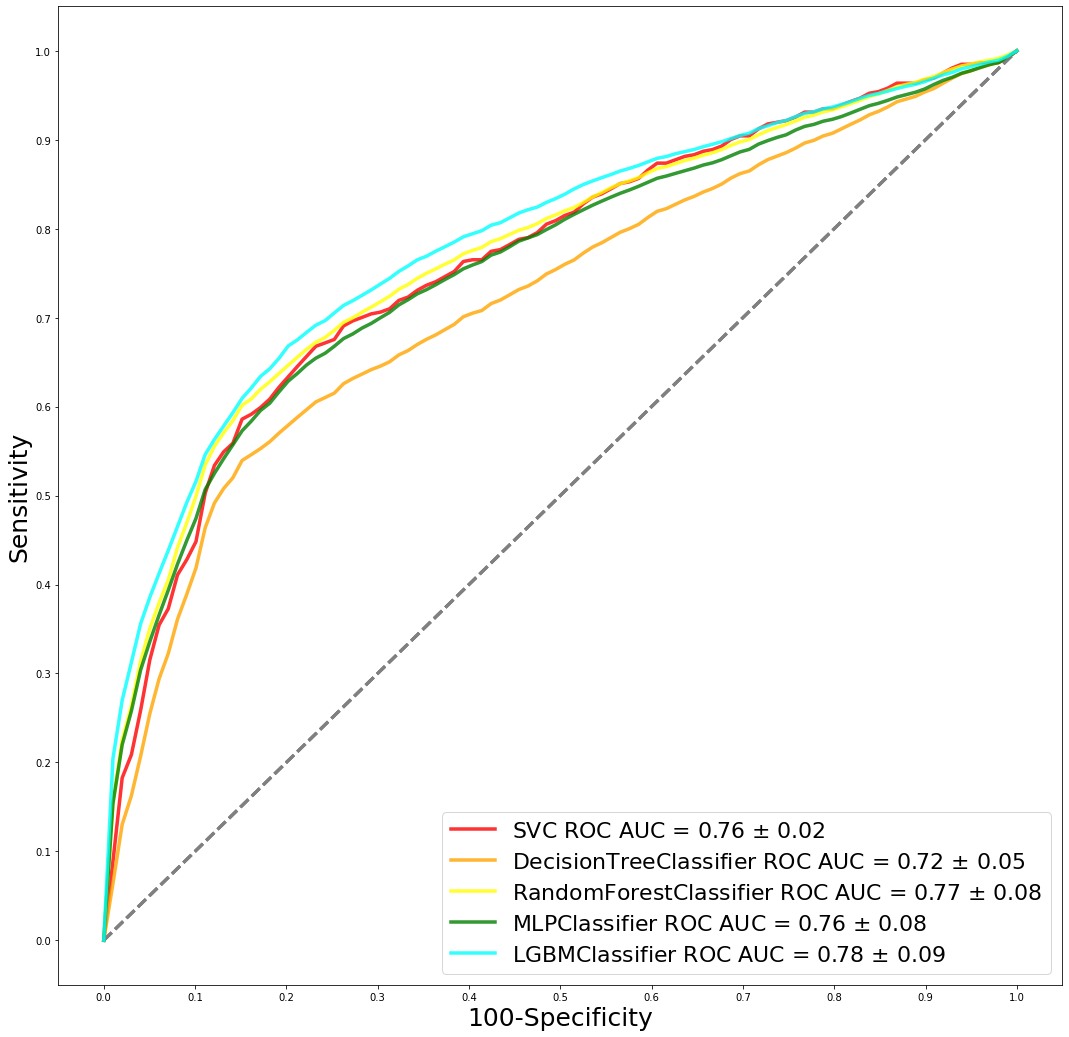

In [7]:
matplotlib.rcParams['figure.figsize'] = (18.0, 18.0)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(0, 1.1, step=0.1))
result = dict()
cv = model_selection.ShuffleSplit(n_splits = 5, test_size = 0.3, random_state = 1)
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']
c = 0
for model in models:
    model_name = str(model).split('(')[0]
    for train, test in cv.split(x_train, y_train):
        probas_ = model.fit(x_train.iloc[train], y_train.iloc[train]).predict_proba(x_train.iloc[test])
     # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
     #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    parameters = {'xtick.labelsize': 22,
                  'ytick.labelsize': 22}
    plt.rcParams.update(parameters)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='gray',alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color=cs[c],label= model_name + r' ROC AUC = %0.2f $\pm$ %0.2f' % (mean_auc, std_auc),lw=3.5, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    c +=1

# 相关的设置被注释掉，可以恢复并查看画图效果。
#plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
#plt.xlim([-0, 1])
#plt.ylim([-0, 1])
    plt.xlabel('100-Specificity', fontsize = 25)
    plt.ylabel('Sensitivity', fontsize = 25)
#plt.title('Receiver operating characteristic example', fontsize = 'x-large')
    plt.legend(loc="lower right" ,prop={"size":22})

plt.savefig('Train_ROC.pdf',dpi=300)
plt.show()


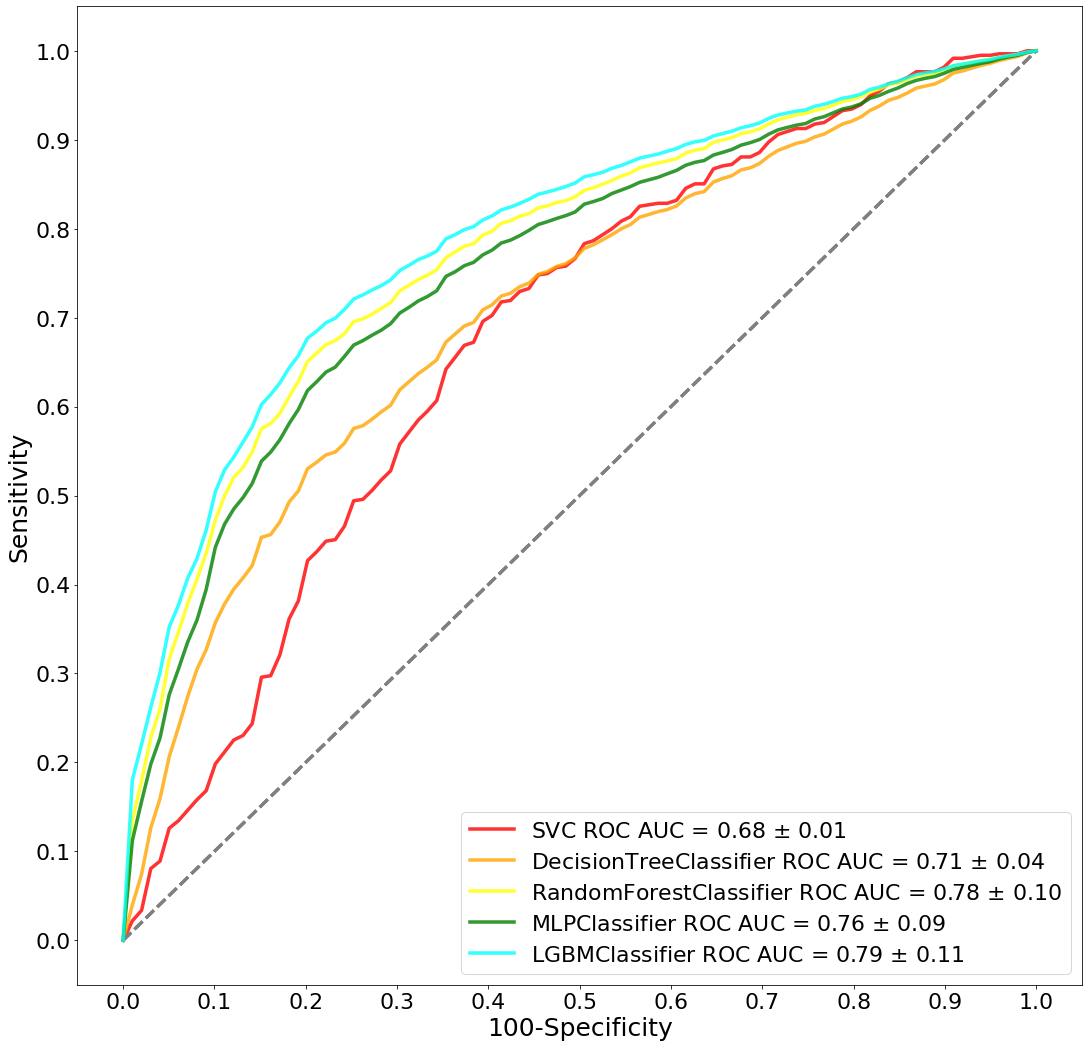

In [9]:
#test
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
lw=2
i = 0
matplotlib.rcParams['figure.figsize'] = (18.0, 18.0)

cc = ClusterCentroids(random_state=0)
X_teresampled, y_teresampled = cc.fit_resample(x_test, y_test)
x_test = X_teresampled
y_test = y_teresampled
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(0, 1.1, step=0.1))
result = dict()
cv = model_selection.ShuffleSplit(n_splits = 5, test_size = 0.3, random_state = 1)
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']
c = 0
for model in models:
    model_name = str(model).split('(')[0]
    for train, test in cv.split(x_train, y_train):
        probas_= model.fit(x_train.iloc[train], y_train.iloc[train]).predict_proba(x_test) #需要修改的是clf，即训练得到的model；以及测试集的X_test和y_test.
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        i += 1       
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='gray',alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color=cs[c],label= model_name + r' ROC AUC = %0.2f $\pm$ %0.2f' % (mean_auc, std_auc),lw=3.5, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.xlabel('100-Specificity', fontsize = 25)
    plt.ylabel('Sensitivity', fontsize = 25)
        #plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right" ,prop={"size":22})
    c +=1

plt.savefig('Test_ROC.pdf',dpi=300)
plt.show()

# Test-optimization

# LGB

In [12]:
lgb_train = lgb.Dataset(x_train, y_train)
### 设置初始参数--不含交叉验证参数
print('设置参数')
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'nthread': 4,
    'learning_rate': 0.01,
    'verbose': -1
    # 'device': 'gpu'
}

### 交叉验证(调参)
print('交叉验证')
min_loss = float('1000')
best_params = {}

# 准确率
print("调参1：提高准确率")
for num_leaves in range(5, 100, 5):
    for max_depth in range(3, 8, 1):
        params['num_leaves'] = num_leaves
        params['max_depth'] = max_depth

        cv_results = lgb.cv(
            params,
            lgb_train,
            seed=1,
            nfold=10,
            metrics=['auc'],
            early_stopping_rounds=10,
            verbose_eval=1
        )
        mean_loss = pd.Series(cv_results['auc-mean']).min()
        boost_rounds = pd.Series(cv_results['auc-mean']).idxmin()

        if mean_loss <= min_loss:
            min_loss = mean_loss
            best_params['num_leaves'] = num_leaves
            best_params['max_depth'] = max_depth
if 'num_leaves' and 'max_depth' in best_params.keys():
    params['num_leaves'] = best_params['num_leaves']
    params['max_depth'] = best_params['max_depth']

# 过拟合

print("调参3：降低过拟合")
for feature_fraction in [0.6, 0.7, 0.8, 0.9, 1.0]:
    for bagging_fraction in [0.6, 0.7, 0.8, 0.9, 1.0]:
        for bagging_freq in range(0, 50, 5):
            params['feature_fraction'] = feature_fraction
            params['bagging_fraction'] = bagging_fraction
            params['bagging_freq'] = bagging_freq

            cv_results = lgb.cv(
                params,
                lgb_train,
                seed=1,
                nfold=10,
                metrics=['auc'],
                early_stopping_rounds=10,
                verbose_eval=-1
            )

            mean_loss = pd.Series(cv_results['auc-mean']).min()
            boost_rounds = pd.Series(cv_results['auc-mean']).idxmin()

            if mean_loss <= min_loss:
                min_loss = mean_loss
                best_params['feature_fraction'] = feature_fraction
                best_params['bagging_fraction'] = bagging_fraction
                best_params['bagging_freq'] = bagging_freq

if 'feature_fraction' and 'bagging_fraction' and 'bagging_freq' in best_params.keys():
    params['feature_fraction'] = best_params['feature_fraction']
    params['bagging_fraction'] = best_params['bagging_fraction']
    params['bagging_freq'] = best_params['bagging_freq']
print("调参4：降低过拟合")
for lambda_l1 in [1e-5, 1e-3, 1e-1, 0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    for lambda_l2 in [1e-5, 1e-3, 1e-1, 0.0, 0.1, 0.4, 0.6, 0.7, 0.9, 1.0]:
        params['lambda_l1'] = lambda_l1
        params['lambda_l2'] = lambda_l2
        cv_results = lgb.cv(
            params,
            lgb_train,
            seed=1,
            nfold=10,
            metrics=['auc'],
            early_stopping_rounds=10,
            verbose_eval=-1
        )

        mean_loss = pd.Series(cv_results['auc-mean']).min()
        boost_rounds = pd.Series(cv_results['auc-mean']).idxmin()

        if mean_loss <= min_loss:
            min_loss = mean_loss
            best_params['lambda_l1'] = lambda_l1
            best_params['lambda_l2'] = lambda_l2
if 'lambda_l1' and 'lambda_l2' in best_params.keys():
    params['lambda_l1'] = best_params['lambda_l1']
    params['lambda_l2'] = best_params['lambda_l2']

print("调参5：降低过拟合2")
for min_split_gain in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    params['min_split_gain'] = min_split_gain

    cv_results = lgb.cv(
        params,
        lgb_train,
        seed=1,
        nfold=10,
        metrics=['auc'],
        early_stopping_rounds=10,
        verbose_eval=-1
    )

    mean_auc = pd.Series(cv_results['auc-mean']).min()
    boost_rounds = pd.Series(cv_results['auc-mean']).idxmin()

    if mean_loss <= min_loss:
        min_loss = mean_loss

        best_params['min_split_gain'] = min_split_gain
if 'min_split_gain' in best_params.keys():
    params['min_split_gain'] = best_params['min_split_gain']

print(best_params)

设置参数
交叉验证
调参1：提高准确率
[1]	cv_agg's auc: 0.783692 + 0.0478701
[2]	cv_agg's auc: 0.783124 + 0.0482766
[3]	cv_agg's auc: 0.783667 + 0.0489219
[4]	cv_agg's auc: 0.790539 + 0.0504658
[5]	cv_agg's auc: 0.791071 + 0.0486782
[6]	cv_agg's auc: 0.793616 + 0.0487427
[7]	cv_agg's auc: 0.793265 + 0.0484547
[8]	cv_agg's auc: 0.800346 + 0.0389975
[9]	cv_agg's auc: 0.798778 + 0.0390572
[10]	cv_agg's auc: 0.80332 + 0.035658
[11]	cv_agg's auc: 0.808294 + 0.0411541
[12]	cv_agg's auc: 0.808615 + 0.0397336
[13]	cv_agg's auc: 0.809602 + 0.0393364
[14]	cv_agg's auc: 0.81039 + 0.0389971
[15]	cv_agg's auc: 0.810587 + 0.0388158
[16]	cv_agg's auc: 0.810972 + 0.0378729
[17]	cv_agg's auc: 0.810844 + 0.0376849
[18]	cv_agg's auc: 0.810683 + 0.0382515
[19]	cv_agg's auc: 0.811511 + 0.038607
[20]	cv_agg's auc: 0.811873 + 0.0381402
[21]	cv_agg's auc: 0.811903 + 0.0382233
[22]	cv_agg's auc: 0.812692 + 0.0375159
[23]	cv_agg's auc: 0.812689 + 0.037507
[24]	cv_agg's auc: 0.812744 + 0.0366007
[25]	cv_agg's auc: 0.812864 + 0.03

[15]	cv_agg's auc: 0.812202 + 0.0388591
[16]	cv_agg's auc: 0.812215 + 0.0380525
[17]	cv_agg's auc: 0.811909 + 0.0384286
[18]	cv_agg's auc: 0.812063 + 0.0379608
[19]	cv_agg's auc: 0.812691 + 0.0377928
[20]	cv_agg's auc: 0.813215 + 0.0390167
[21]	cv_agg's auc: 0.813669 + 0.0386255
[22]	cv_agg's auc: 0.813355 + 0.0381051
[23]	cv_agg's auc: 0.813847 + 0.0373727
[24]	cv_agg's auc: 0.815039 + 0.0369854
[25]	cv_agg's auc: 0.813631 + 0.0360042
[26]	cv_agg's auc: 0.814443 + 0.0356546
[27]	cv_agg's auc: 0.813919 + 0.0347781
[28]	cv_agg's auc: 0.813139 + 0.0363713
[29]	cv_agg's auc: 0.812481 + 0.0356917
[30]	cv_agg's auc: 0.813712 + 0.0347593
[31]	cv_agg's auc: 0.81366 + 0.0346418
[32]	cv_agg's auc: 0.813424 + 0.0348805
[33]	cv_agg's auc: 0.817854 + 0.0349333
[34]	cv_agg's auc: 0.819788 + 0.0418142
[35]	cv_agg's auc: 0.820012 + 0.0417275
[36]	cv_agg's auc: 0.821321 + 0.0402421
[37]	cv_agg's auc: 0.822468 + 0.0399584
[38]	cv_agg's auc: 0.82359 + 0.0404059
[39]	cv_agg's auc: 0.822715 + 0.0403716
[4

[51]	cv_agg's auc: 0.825987 + 0.0393911
[52]	cv_agg's auc: 0.826326 + 0.0387605
[53]	cv_agg's auc: 0.826999 + 0.0389721
[54]	cv_agg's auc: 0.827638 + 0.0384555
[55]	cv_agg's auc: 0.828864 + 0.0381205
[56]	cv_agg's auc: 0.829421 + 0.0379221
[57]	cv_agg's auc: 0.831109 + 0.0377337
[58]	cv_agg's auc: 0.832224 + 0.0363829
[59]	cv_agg's auc: 0.832622 + 0.0371221
[60]	cv_agg's auc: 0.833301 + 0.0376958
[61]	cv_agg's auc: 0.833646 + 0.0376933
[62]	cv_agg's auc: 0.833824 + 0.0378566
[63]	cv_agg's auc: 0.834007 + 0.0378986
[64]	cv_agg's auc: 0.834296 + 0.0379464
[65]	cv_agg's auc: 0.834092 + 0.0379111
[66]	cv_agg's auc: 0.835467 + 0.0375049
[67]	cv_agg's auc: 0.836226 + 0.0375682
[68]	cv_agg's auc: 0.836473 + 0.0375149
[69]	cv_agg's auc: 0.836451 + 0.0376697
[70]	cv_agg's auc: 0.836749 + 0.0379271
[71]	cv_agg's auc: 0.837462 + 0.0386302
[72]	cv_agg's auc: 0.83719 + 0.0386101
[73]	cv_agg's auc: 0.837839 + 0.0387877
[74]	cv_agg's auc: 0.838138 + 0.0386294
[75]	cv_agg's auc: 0.838851 + 0.0385602
[

[86]	cv_agg's auc: 0.853158 + 0.0355106
[87]	cv_agg's auc: 0.854064 + 0.0348412
[88]	cv_agg's auc: 0.854673 + 0.0349752
[89]	cv_agg's auc: 0.854672 + 0.0350525
[90]	cv_agg's auc: 0.854941 + 0.0350994
[91]	cv_agg's auc: 0.855674 + 0.0350617
[92]	cv_agg's auc: 0.856005 + 0.0342191
[93]	cv_agg's auc: 0.855881 + 0.0341773
[94]	cv_agg's auc: 0.855833 + 0.0341534
[95]	cv_agg's auc: 0.856146 + 0.0340439
[96]	cv_agg's auc: 0.856122 + 0.0337871
[97]	cv_agg's auc: 0.856147 + 0.0339685
[98]	cv_agg's auc: 0.856555 + 0.0343043
[99]	cv_agg's auc: 0.856643 + 0.0342815
[100]	cv_agg's auc: 0.856956 + 0.0345054
[1]	cv_agg's auc: 0.788244 + 0.042506
[2]	cv_agg's auc: 0.791395 + 0.044786
[3]	cv_agg's auc: 0.792491 + 0.0450541
[4]	cv_agg's auc: 0.800067 + 0.0472707
[5]	cv_agg's auc: 0.801535 + 0.0475559
[6]	cv_agg's auc: 0.802586 + 0.0479091
[7]	cv_agg's auc: 0.804262 + 0.0468478
[8]	cv_agg's auc: 0.804751 + 0.0464223
[9]	cv_agg's auc: 0.806829 + 0.0433543
[10]	cv_agg's auc: 0.810535 + 0.0392136
[11]	cv_ag

[5]	cv_agg's auc: 0.80211 + 0.0476805
[6]	cv_agg's auc: 0.802874 + 0.0479583
[7]	cv_agg's auc: 0.804262 + 0.0468478
[8]	cv_agg's auc: 0.805149 + 0.0465066
[9]	cv_agg's auc: 0.80705 + 0.0433831
[10]	cv_agg's auc: 0.811275 + 0.0392546
[11]	cv_agg's auc: 0.816027 + 0.0347215
[12]	cv_agg's auc: 0.818134 + 0.0343667
[13]	cv_agg's auc: 0.818468 + 0.0349939
[14]	cv_agg's auc: 0.819741 + 0.0349795
[15]	cv_agg's auc: 0.819681 + 0.0333642
[16]	cv_agg's auc: 0.819885 + 0.0324404
[17]	cv_agg's auc: 0.819565 + 0.0328557
[18]	cv_agg's auc: 0.819606 + 0.0311627
[19]	cv_agg's auc: 0.819235 + 0.0306429
[20]	cv_agg's auc: 0.820571 + 0.030775
[21]	cv_agg's auc: 0.82076 + 0.0302802
[22]	cv_agg's auc: 0.821388 + 0.0295362
[23]	cv_agg's auc: 0.822249 + 0.029199
[24]	cv_agg's auc: 0.822879 + 0.0286885
[25]	cv_agg's auc: 0.825502 + 0.0284708
[26]	cv_agg's auc: 0.825484 + 0.0279606
[27]	cv_agg's auc: 0.826199 + 0.0279283
[28]	cv_agg's auc: 0.825971 + 0.0270826
[29]	cv_agg's auc: 0.825496 + 0.0270985
[30]	cv_ag

[53]	cv_agg's auc: 0.846966 + 0.0272806
[54]	cv_agg's auc: 0.846808 + 0.0277967
[55]	cv_agg's auc: 0.847511 + 0.0282757
[56]	cv_agg's auc: 0.849579 + 0.0301772
[57]	cv_agg's auc: 0.849982 + 0.030016
[58]	cv_agg's auc: 0.850415 + 0.0300008
[59]	cv_agg's auc: 0.850743 + 0.0298405
[60]	cv_agg's auc: 0.850858 + 0.030129
[61]	cv_agg's auc: 0.850746 + 0.0297858
[62]	cv_agg's auc: 0.851057 + 0.0304343
[63]	cv_agg's auc: 0.851552 + 0.0302608
[64]	cv_agg's auc: 0.852365 + 0.0305577
[65]	cv_agg's auc: 0.852239 + 0.031007
[66]	cv_agg's auc: 0.852652 + 0.0311127
[67]	cv_agg's auc: 0.852475 + 0.0320478
[68]	cv_agg's auc: 0.852967 + 0.0321092
[69]	cv_agg's auc: 0.85346 + 0.0323701
[70]	cv_agg's auc: 0.853737 + 0.0325515
[71]	cv_agg's auc: 0.85385 + 0.0329239
[72]	cv_agg's auc: 0.853283 + 0.0331595
[73]	cv_agg's auc: 0.854754 + 0.0326319
[74]	cv_agg's auc: 0.855567 + 0.0323366
[75]	cv_agg's auc: 0.856206 + 0.0313735
[76]	cv_agg's auc: 0.856477 + 0.0317171
[77]	cv_agg's auc: 0.856637 + 0.0315377
[78]	

[66]	cv_agg's auc: 0.858669 + 0.0278944
[67]	cv_agg's auc: 0.859202 + 0.027749
[68]	cv_agg's auc: 0.859409 + 0.0275092
[69]	cv_agg's auc: 0.859437 + 0.0277678
[70]	cv_agg's auc: 0.859573 + 0.0280308
[71]	cv_agg's auc: 0.859832 + 0.0281772
[72]	cv_agg's auc: 0.859294 + 0.0289952
[73]	cv_agg's auc: 0.859869 + 0.0282541
[74]	cv_agg's auc: 0.860706 + 0.0285236
[75]	cv_agg's auc: 0.860179 + 0.0288811
[76]	cv_agg's auc: 0.860193 + 0.0290705
[77]	cv_agg's auc: 0.860653 + 0.0289598
[78]	cv_agg's auc: 0.861583 + 0.0281008
[79]	cv_agg's auc: 0.861682 + 0.0281525
[80]	cv_agg's auc: 0.862191 + 0.0285105
[81]	cv_agg's auc: 0.861836 + 0.0289255
[82]	cv_agg's auc: 0.862021 + 0.0290318
[83]	cv_agg's auc: 0.862066 + 0.0293599
[84]	cv_agg's auc: 0.862315 + 0.0290351
[85]	cv_agg's auc: 0.862246 + 0.029374
[86]	cv_agg's auc: 0.862585 + 0.0296015
[87]	cv_agg's auc: 0.862761 + 0.0295552
[88]	cv_agg's auc: 0.862987 + 0.0299093
[89]	cv_agg's auc: 0.864013 + 0.0292491
[90]	cv_agg's auc: 0.864045 + 0.0296805
[9

[96]	cv_agg's auc: 0.848595 + 0.0347494
[97]	cv_agg's auc: 0.848887 + 0.0352174
[98]	cv_agg's auc: 0.849184 + 0.0351921
[99]	cv_agg's auc: 0.849045 + 0.0352895
[100]	cv_agg's auc: 0.849382 + 0.0353543
[1]	cv_agg's auc: 0.799841 + 0.0445033
[2]	cv_agg's auc: 0.799195 + 0.0434851
[3]	cv_agg's auc: 0.798437 + 0.0439405
[4]	cv_agg's auc: 0.804022 + 0.0437418
[5]	cv_agg's auc: 0.808759 + 0.0459053
[6]	cv_agg's auc: 0.808467 + 0.0464644
[7]	cv_agg's auc: 0.810245 + 0.0483359
[8]	cv_agg's auc: 0.81591 + 0.0441191
[9]	cv_agg's auc: 0.815556 + 0.0448476
[10]	cv_agg's auc: 0.817803 + 0.042632
[11]	cv_agg's auc: 0.822651 + 0.0383258
[12]	cv_agg's auc: 0.82272 + 0.0373573
[13]	cv_agg's auc: 0.825311 + 0.0366445
[14]	cv_agg's auc: 0.82611 + 0.036259
[15]	cv_agg's auc: 0.826792 + 0.0365435
[16]	cv_agg's auc: 0.826787 + 0.0360554
[17]	cv_agg's auc: 0.82974 + 0.0338211
[18]	cv_agg's auc: 0.83034 + 0.0331018
[19]	cv_agg's auc: 0.830568 + 0.0319449
[20]	cv_agg's auc: 0.830226 + 0.0321279
[21]	cv_agg's a

[8]	cv_agg's auc: 0.814598 + 0.0441976
[9]	cv_agg's auc: 0.818029 + 0.0435654
[10]	cv_agg's auc: 0.819221 + 0.0447642
[11]	cv_agg's auc: 0.818748 + 0.0448164
[12]	cv_agg's auc: 0.822617 + 0.0414267
[13]	cv_agg's auc: 0.823077 + 0.0403437
[14]	cv_agg's auc: 0.824318 + 0.0392128
[15]	cv_agg's auc: 0.825986 + 0.0393866
[16]	cv_agg's auc: 0.826926 + 0.0403731
[17]	cv_agg's auc: 0.82631 + 0.0383375
[18]	cv_agg's auc: 0.830226 + 0.0382261
[19]	cv_agg's auc: 0.830456 + 0.0380384
[20]	cv_agg's auc: 0.829847 + 0.0377906
[21]	cv_agg's auc: 0.831918 + 0.0376152
[22]	cv_agg's auc: 0.83147 + 0.0375738
[23]	cv_agg's auc: 0.83309 + 0.0394967
[24]	cv_agg's auc: 0.832803 + 0.0395172
[25]	cv_agg's auc: 0.832871 + 0.0392809
[26]	cv_agg's auc: 0.833198 + 0.0390479
[27]	cv_agg's auc: 0.83311 + 0.0380235
[28]	cv_agg's auc: 0.835252 + 0.0352049
[29]	cv_agg's auc: 0.83649 + 0.034043
[30]	cv_agg's auc: 0.837204 + 0.0335475
[31]	cv_agg's auc: 0.838426 + 0.0336296
[32]	cv_agg's auc: 0.838318 + 0.0329258
[33]	cv_

[22]	cv_agg's auc: 0.823041 + 0.029382
[23]	cv_agg's auc: 0.82392 + 0.0282368
[24]	cv_agg's auc: 0.824436 + 0.0281996
[25]	cv_agg's auc: 0.824804 + 0.0281741
[26]	cv_agg's auc: 0.82713 + 0.0264554
[27]	cv_agg's auc: 0.827305 + 0.0268284
[28]	cv_agg's auc: 0.826662 + 0.0263651
[29]	cv_agg's auc: 0.827457 + 0.0283899
[30]	cv_agg's auc: 0.827702 + 0.0279784
[31]	cv_agg's auc: 0.827463 + 0.0277555
[32]	cv_agg's auc: 0.826668 + 0.0278694
[33]	cv_agg's auc: 0.826256 + 0.0270589
[34]	cv_agg's auc: 0.827155 + 0.0278651
[35]	cv_agg's auc: 0.829652 + 0.0266233
[36]	cv_agg's auc: 0.830285 + 0.026191
[37]	cv_agg's auc: 0.829856 + 0.0261153
[38]	cv_agg's auc: 0.831794 + 0.0260337
[39]	cv_agg's auc: 0.834893 + 0.0277219
[40]	cv_agg's auc: 0.835245 + 0.0277533
[41]	cv_agg's auc: 0.83571 + 0.0280382
[42]	cv_agg's auc: 0.836185 + 0.0281485
[43]	cv_agg's auc: 0.836424 + 0.029723
[44]	cv_agg's auc: 0.838752 + 0.0299332
[45]	cv_agg's auc: 0.839098 + 0.0303421
[46]	cv_agg's auc: 0.839171 + 0.0305278
[47]	c

[50]	cv_agg's auc: 0.85193 + 0.0301356
[51]	cv_agg's auc: 0.852899 + 0.0306594
[52]	cv_agg's auc: 0.854032 + 0.03076
[53]	cv_agg's auc: 0.854177 + 0.0305543
[54]	cv_agg's auc: 0.854428 + 0.0304603
[55]	cv_agg's auc: 0.854799 + 0.0309456
[56]	cv_agg's auc: 0.854926 + 0.0309501
[57]	cv_agg's auc: 0.855704 + 0.030709
[58]	cv_agg's auc: 0.855858 + 0.0302903
[59]	cv_agg's auc: 0.856488 + 0.0299649
[60]	cv_agg's auc: 0.856938 + 0.030192
[61]	cv_agg's auc: 0.85726 + 0.0301852
[62]	cv_agg's auc: 0.857734 + 0.0298279
[63]	cv_agg's auc: 0.85847 + 0.0300271
[64]	cv_agg's auc: 0.859258 + 0.0301507
[65]	cv_agg's auc: 0.859501 + 0.0299832
[66]	cv_agg's auc: 0.859929 + 0.0297206
[67]	cv_agg's auc: 0.860013 + 0.0300616
[68]	cv_agg's auc: 0.859741 + 0.0300964
[69]	cv_agg's auc: 0.860822 + 0.0299666
[70]	cv_agg's auc: 0.861284 + 0.0295245
[71]	cv_agg's auc: 0.861624 + 0.029518
[72]	cv_agg's auc: 0.861708 + 0.0292785
[73]	cv_agg's auc: 0.862168 + 0.0290218
[74]	cv_agg's auc: 0.862347 + 0.0286995
[75]	cv_

[64]	cv_agg's auc: 0.857589 + 0.0300684
[65]	cv_agg's auc: 0.858359 + 0.0300791
[66]	cv_agg's auc: 0.858637 + 0.0298332
[67]	cv_agg's auc: 0.859056 + 0.0297651
[68]	cv_agg's auc: 0.859209 + 0.0301187
[69]	cv_agg's auc: 0.859809 + 0.0300645
[70]	cv_agg's auc: 0.859868 + 0.030206
[71]	cv_agg's auc: 0.860764 + 0.0304375
[72]	cv_agg's auc: 0.861052 + 0.0300871
[73]	cv_agg's auc: 0.860903 + 0.0304037
[74]	cv_agg's auc: 0.861678 + 0.0307974
[75]	cv_agg's auc: 0.862624 + 0.0308626
[76]	cv_agg's auc: 0.862506 + 0.0309715
[77]	cv_agg's auc: 0.86291 + 0.0310411
[78]	cv_agg's auc: 0.86288 + 0.0309636
[79]	cv_agg's auc: 0.86374 + 0.0306061
[80]	cv_agg's auc: 0.865096 + 0.0305417
[81]	cv_agg's auc: 0.865076 + 0.0307762
[82]	cv_agg's auc: 0.8653 + 0.0307219
[83]	cv_agg's auc: 0.86526 + 0.0308443
[84]	cv_agg's auc: 0.865775 + 0.0308214
[85]	cv_agg's auc: 0.865591 + 0.030785
[86]	cv_agg's auc: 0.865592 + 0.0309729
[87]	cv_agg's auc: 0.865383 + 0.031376
[88]	cv_agg's auc: 0.865635 + 0.0313442
[89]	cv_a

[98]	cv_agg's auc: 0.859986 + 0.035958
[99]	cv_agg's auc: 0.859919 + 0.0361814
[100]	cv_agg's auc: 0.86012 + 0.0361188
[1]	cv_agg's auc: 0.795379 + 0.040663
[2]	cv_agg's auc: 0.791362 + 0.0428516
[3]	cv_agg's auc: 0.793544 + 0.0421515
[4]	cv_agg's auc: 0.796112 + 0.0437947
[5]	cv_agg's auc: 0.800053 + 0.046822
[6]	cv_agg's auc: 0.806437 + 0.0475124
[7]	cv_agg's auc: 0.80922 + 0.0482548
[8]	cv_agg's auc: 0.810222 + 0.0506517
[9]	cv_agg's auc: 0.814248 + 0.0481848
[10]	cv_agg's auc: 0.815526 + 0.0473136
[11]	cv_agg's auc: 0.817356 + 0.0454048
[12]	cv_agg's auc: 0.822136 + 0.0420448
[13]	cv_agg's auc: 0.822727 + 0.0419584
[14]	cv_agg's auc: 0.824978 + 0.0414602
[15]	cv_agg's auc: 0.826537 + 0.0416545
[16]	cv_agg's auc: 0.826832 + 0.0425274
[17]	cv_agg's auc: 0.827475 + 0.0423736
[18]	cv_agg's auc: 0.82792 + 0.0428529
[19]	cv_agg's auc: 0.829369 + 0.0419879
[20]	cv_agg's auc: 0.829099 + 0.042564
[21]	cv_agg's auc: 0.828191 + 0.0425122
[22]	cv_agg's auc: 0.830227 + 0.0426867
[23]	cv_agg's a

[24]	cv_agg's auc: 0.842846 + 0.0437762
[25]	cv_agg's auc: 0.844101 + 0.0433544
[26]	cv_agg's auc: 0.844665 + 0.0425546
[27]	cv_agg's auc: 0.845932 + 0.0407435
[28]	cv_agg's auc: 0.845953 + 0.0403191
[29]	cv_agg's auc: 0.847052 + 0.0398367
[30]	cv_agg's auc: 0.846219 + 0.0394042
[31]	cv_agg's auc: 0.847032 + 0.0389228
[32]	cv_agg's auc: 0.847243 + 0.0385269
[33]	cv_agg's auc: 0.847724 + 0.037954
[34]	cv_agg's auc: 0.847701 + 0.0375873
[35]	cv_agg's auc: 0.84836 + 0.0366663
[36]	cv_agg's auc: 0.84919 + 0.0362027
[37]	cv_agg's auc: 0.848969 + 0.0361179
[38]	cv_agg's auc: 0.849305 + 0.0356661
[39]	cv_agg's auc: 0.850057 + 0.0351
[40]	cv_agg's auc: 0.850991 + 0.0342122
[41]	cv_agg's auc: 0.851131 + 0.0337502
[42]	cv_agg's auc: 0.851113 + 0.0332399
[43]	cv_agg's auc: 0.851163 + 0.033372
[44]	cv_agg's auc: 0.851693 + 0.0328201
[45]	cv_agg's auc: 0.851868 + 0.0322942
[46]	cv_agg's auc: 0.852051 + 0.0319252
[47]	cv_agg's auc: 0.85284 + 0.0319231
[48]	cv_agg's auc: 0.853206 + 0.0317441
[49]	cv_

[41]	cv_agg's auc: 0.8384 + 0.0286686
[42]	cv_agg's auc: 0.840231 + 0.0309535
[43]	cv_agg's auc: 0.841449 + 0.0288628
[44]	cv_agg's auc: 0.841292 + 0.0293684
[45]	cv_agg's auc: 0.843457 + 0.0284492
[46]	cv_agg's auc: 0.844061 + 0.0280342
[47]	cv_agg's auc: 0.844543 + 0.0277964
[48]	cv_agg's auc: 0.844325 + 0.0277103
[49]	cv_agg's auc: 0.844618 + 0.0277952
[50]	cv_agg's auc: 0.845725 + 0.0275745
[51]	cv_agg's auc: 0.846137 + 0.0275543
[52]	cv_agg's auc: 0.846626 + 0.0275653
[53]	cv_agg's auc: 0.84709 + 0.0275254
[54]	cv_agg's auc: 0.846819 + 0.0279689
[55]	cv_agg's auc: 0.847454 + 0.0284216
[56]	cv_agg's auc: 0.850102 + 0.0299049
[57]	cv_agg's auc: 0.850677 + 0.0297902
[58]	cv_agg's auc: 0.851086 + 0.0297025
[59]	cv_agg's auc: 0.851107 + 0.0297256
[60]	cv_agg's auc: 0.851246 + 0.0299997
[61]	cv_agg's auc: 0.85109 + 0.0297502
[62]	cv_agg's auc: 0.851377 + 0.0304182
[63]	cv_agg's auc: 0.851783 + 0.0302845
[64]	cv_agg's auc: 0.852549 + 0.0306544
[65]	cv_agg's auc: 0.852581 + 0.0309941
[66]

[62]	cv_agg's auc: 0.859923 + 0.0292424
[63]	cv_agg's auc: 0.86024 + 0.0295802
[64]	cv_agg's auc: 0.860817 + 0.02964
[65]	cv_agg's auc: 0.861202 + 0.0298518
[66]	cv_agg's auc: 0.861382 + 0.0295209
[67]	cv_agg's auc: 0.862149 + 0.0297391
[68]	cv_agg's auc: 0.862465 + 0.0296001
[69]	cv_agg's auc: 0.863184 + 0.0296678
[70]	cv_agg's auc: 0.863195 + 0.0301991
[71]	cv_agg's auc: 0.863898 + 0.0300799
[72]	cv_agg's auc: 0.864357 + 0.0302602
[73]	cv_agg's auc: 0.864554 + 0.0299857
[74]	cv_agg's auc: 0.864548 + 0.0301326
[75]	cv_agg's auc: 0.864882 + 0.0304241
[76]	cv_agg's auc: 0.864927 + 0.0306742
[77]	cv_agg's auc: 0.865128 + 0.0303721
[78]	cv_agg's auc: 0.865351 + 0.0305789
[79]	cv_agg's auc: 0.865945 + 0.0304915
[80]	cv_agg's auc: 0.866237 + 0.0305304
[81]	cv_agg's auc: 0.866061 + 0.0303967
[82]	cv_agg's auc: 0.866392 + 0.0304932
[83]	cv_agg's auc: 0.866968 + 0.0303159
[84]	cv_agg's auc: 0.867082 + 0.0299087
[85]	cv_agg's auc: 0.866857 + 0.0298458
[86]	cv_agg's auc: 0.866893 + 0.030047
[87]

[75]	cv_agg's auc: 0.843481 + 0.0343911
[76]	cv_agg's auc: 0.843325 + 0.0346158
[77]	cv_agg's auc: 0.843304 + 0.0348531
[78]	cv_agg's auc: 0.844129 + 0.0345245
[79]	cv_agg's auc: 0.844282 + 0.0345204
[80]	cv_agg's auc: 0.844831 + 0.0344529
[81]	cv_agg's auc: 0.845032 + 0.0343976
[82]	cv_agg's auc: 0.847255 + 0.0345194
[83]	cv_agg's auc: 0.847094 + 0.0345368
[84]	cv_agg's auc: 0.847471 + 0.0345959
[85]	cv_agg's auc: 0.847418 + 0.0345003
[86]	cv_agg's auc: 0.847449 + 0.033843
[87]	cv_agg's auc: 0.847272 + 0.0340973
[88]	cv_agg's auc: 0.847679 + 0.0343886
[89]	cv_agg's auc: 0.84774 + 0.0345535
[90]	cv_agg's auc: 0.847601 + 0.0343181
[91]	cv_agg's auc: 0.848019 + 0.0345714
[92]	cv_agg's auc: 0.848014 + 0.0345143
[93]	cv_agg's auc: 0.848083 + 0.0347777
[94]	cv_agg's auc: 0.848131 + 0.0349394
[95]	cv_agg's auc: 0.848344 + 0.0350406
[96]	cv_agg's auc: 0.848595 + 0.0347494
[97]	cv_agg's auc: 0.848887 + 0.0352174
[98]	cv_agg's auc: 0.849184 + 0.0351921
[99]	cv_agg's auc: 0.849045 + 0.0352895
[1

[6]	cv_agg's auc: 0.808591 + 0.0501897
[7]	cv_agg's auc: 0.812444 + 0.0489593
[8]	cv_agg's auc: 0.816471 + 0.0480002
[9]	cv_agg's auc: 0.817117 + 0.0486009
[10]	cv_agg's auc: 0.822284 + 0.045495
[11]	cv_agg's auc: 0.822038 + 0.0449152
[12]	cv_agg's auc: 0.827563 + 0.0402204
[13]	cv_agg's auc: 0.829806 + 0.0406963
[14]	cv_agg's auc: 0.829603 + 0.0404634
[15]	cv_agg's auc: 0.832657 + 0.0414091
[16]	cv_agg's auc: 0.832596 + 0.040946
[17]	cv_agg's auc: 0.832522 + 0.0420302
[18]	cv_agg's auc: 0.832633 + 0.0419742
[19]	cv_agg's auc: 0.835447 + 0.0432337
[20]	cv_agg's auc: 0.837304 + 0.0465129
[21]	cv_agg's auc: 0.83853 + 0.0456273
[22]	cv_agg's auc: 0.838346 + 0.0452831
[23]	cv_agg's auc: 0.840281 + 0.0436199
[24]	cv_agg's auc: 0.842189 + 0.0424363
[25]	cv_agg's auc: 0.842083 + 0.0417479
[26]	cv_agg's auc: 0.841865 + 0.0419355
[27]	cv_agg's auc: 0.843281 + 0.0413147
[28]	cv_agg's auc: 0.843416 + 0.0411725
[29]	cv_agg's auc: 0.845018 + 0.0391349
[30]	cv_agg's auc: 0.845423 + 0.0386422
[31]	cv

[74]	cv_agg's auc: 0.843006 + 0.0340802
[75]	cv_agg's auc: 0.843481 + 0.0343911
[76]	cv_agg's auc: 0.843325 + 0.0346158
[77]	cv_agg's auc: 0.843304 + 0.0348531
[78]	cv_agg's auc: 0.844129 + 0.0345245
[79]	cv_agg's auc: 0.844282 + 0.0345204
[80]	cv_agg's auc: 0.844831 + 0.0344529
[81]	cv_agg's auc: 0.845032 + 0.0343976
[82]	cv_agg's auc: 0.847255 + 0.0345194
[83]	cv_agg's auc: 0.847094 + 0.0345368
[84]	cv_agg's auc: 0.847471 + 0.0345959
[85]	cv_agg's auc: 0.847418 + 0.0345003
[86]	cv_agg's auc: 0.847449 + 0.033843
[87]	cv_agg's auc: 0.847272 + 0.0340973
[88]	cv_agg's auc: 0.847679 + 0.0343886
[89]	cv_agg's auc: 0.84774 + 0.0345535
[90]	cv_agg's auc: 0.847601 + 0.0343181
[91]	cv_agg's auc: 0.848019 + 0.0345714
[92]	cv_agg's auc: 0.848014 + 0.0345143
[93]	cv_agg's auc: 0.848083 + 0.0347777
[94]	cv_agg's auc: 0.848131 + 0.0349394
[95]	cv_agg's auc: 0.848344 + 0.0350406
[96]	cv_agg's auc: 0.848595 + 0.0347494
[97]	cv_agg's auc: 0.848887 + 0.0352174
[98]	cv_agg's auc: 0.849184 + 0.0351921
[9

[88]	cv_agg's auc: 0.865335 + 0.030081
[89]	cv_agg's auc: 0.865708 + 0.0305496
[90]	cv_agg's auc: 0.865547 + 0.0304473
[91]	cv_agg's auc: 0.865547 + 0.0307207
[92]	cv_agg's auc: 0.865864 + 0.0307072
[93]	cv_agg's auc: 0.866338 + 0.0307098
[94]	cv_agg's auc: 0.866167 + 0.0308543
[95]	cv_agg's auc: 0.866269 + 0.0309332
[96]	cv_agg's auc: 0.866179 + 0.0314138
[97]	cv_agg's auc: 0.866176 + 0.0314584
[98]	cv_agg's auc: 0.866382 + 0.0317107
[99]	cv_agg's auc: 0.866498 + 0.031887
[100]	cv_agg's auc: 0.866731 + 0.0320361
[1]	cv_agg's auc: 0.789456 + 0.0353108
[2]	cv_agg's auc: 0.788831 + 0.0405126
[3]	cv_agg's auc: 0.787663 + 0.0454015
[4]	cv_agg's auc: 0.787452 + 0.0481274
[5]	cv_agg's auc: 0.796626 + 0.0469047
[6]	cv_agg's auc: 0.808591 + 0.0501897
[7]	cv_agg's auc: 0.812444 + 0.0489593
[8]	cv_agg's auc: 0.816471 + 0.0480002
[9]	cv_agg's auc: 0.817117 + 0.0486009
[10]	cv_agg's auc: 0.822284 + 0.045495
[11]	cv_agg's auc: 0.822038 + 0.0449152
[12]	cv_agg's auc: 0.827563 + 0.0402204
[13]	cv_agg

[99]	cv_agg's auc: 0.868641 + 0.0296931
[100]	cv_agg's auc: 0.868531 + 0.0295784
[1]	cv_agg's auc: 0.792241 + 0.0449548
[2]	cv_agg's auc: 0.792468 + 0.0451763
[3]	cv_agg's auc: 0.792778 + 0.045795
[4]	cv_agg's auc: 0.798936 + 0.0465779
[5]	cv_agg's auc: 0.801323 + 0.0470982
[6]	cv_agg's auc: 0.802077 + 0.0460845
[7]	cv_agg's auc: 0.80345 + 0.0450524
[8]	cv_agg's auc: 0.804231 + 0.0437608
[9]	cv_agg's auc: 0.809933 + 0.0396147
[10]	cv_agg's auc: 0.814428 + 0.0362117
[11]	cv_agg's auc: 0.816809 + 0.0341014
[12]	cv_agg's auc: 0.818087 + 0.0320448
[13]	cv_agg's auc: 0.818301 + 0.0320567
[14]	cv_agg's auc: 0.819868 + 0.0330548
[15]	cv_agg's auc: 0.819868 + 0.0319496
[16]	cv_agg's auc: 0.821603 + 0.0310301
[17]	cv_agg's auc: 0.821404 + 0.0308607
[18]	cv_agg's auc: 0.822515 + 0.0315407
[19]	cv_agg's auc: 0.821925 + 0.0308219
[20]	cv_agg's auc: 0.821638 + 0.0312471
[21]	cv_agg's auc: 0.823414 + 0.0304514
[22]	cv_agg's auc: 0.823041 + 0.029382
[23]	cv_agg's auc: 0.82392 + 0.0282368
[24]	cv_agg'

[7]	cv_agg's auc: 0.80922 + 0.0482548
[8]	cv_agg's auc: 0.810222 + 0.0506517
[9]	cv_agg's auc: 0.814248 + 0.0481848
[10]	cv_agg's auc: 0.815526 + 0.0473136
[11]	cv_agg's auc: 0.817356 + 0.0454048
[12]	cv_agg's auc: 0.822136 + 0.0420448
[13]	cv_agg's auc: 0.822727 + 0.0419584
[14]	cv_agg's auc: 0.824978 + 0.0414602
[15]	cv_agg's auc: 0.826537 + 0.0416545
[16]	cv_agg's auc: 0.826832 + 0.0425274
[17]	cv_agg's auc: 0.827475 + 0.0423736
[18]	cv_agg's auc: 0.82792 + 0.0428529
[19]	cv_agg's auc: 0.829369 + 0.0419879
[20]	cv_agg's auc: 0.829099 + 0.042564
[21]	cv_agg's auc: 0.828191 + 0.0425122
[22]	cv_agg's auc: 0.830227 + 0.0426867
[23]	cv_agg's auc: 0.833118 + 0.0392212
[24]	cv_agg's auc: 0.832776 + 0.039519
[25]	cv_agg's auc: 0.833634 + 0.0392359
[26]	cv_agg's auc: 0.834598 + 0.0374314
[27]	cv_agg's auc: 0.83454 + 0.0376768
[28]	cv_agg's auc: 0.835461 + 0.0369892
[29]	cv_agg's auc: 0.837533 + 0.0359444
[30]	cv_agg's auc: 0.837967 + 0.0351542
[31]	cv_agg's auc: 0.838615 + 0.0347417
[32]	cv_

[30]	cv_agg's auc: 0.846232 + 0.0399157
[31]	cv_agg's auc: 0.846966 + 0.0394979
[32]	cv_agg's auc: 0.847604 + 0.0382128
[33]	cv_agg's auc: 0.847605 + 0.0377592
[34]	cv_agg's auc: 0.848173 + 0.0366542
[35]	cv_agg's auc: 0.848453 + 0.0358454
[36]	cv_agg's auc: 0.848683 + 0.0365974
[37]	cv_agg's auc: 0.849631 + 0.0350207
[38]	cv_agg's auc: 0.849788 + 0.034646
[39]	cv_agg's auc: 0.849567 + 0.0343268
[40]	cv_agg's auc: 0.851382 + 0.0332258
[41]	cv_agg's auc: 0.851453 + 0.0329937
[42]	cv_agg's auc: 0.852202 + 0.0329117
[43]	cv_agg's auc: 0.852262 + 0.032573
[44]	cv_agg's auc: 0.852357 + 0.0325029
[45]	cv_agg's auc: 0.853008 + 0.0319556
[46]	cv_agg's auc: 0.853125 + 0.0314135
[47]	cv_agg's auc: 0.85285 + 0.0313702
[48]	cv_agg's auc: 0.853041 + 0.0308343
[49]	cv_agg's auc: 0.85326 + 0.0311872
[50]	cv_agg's auc: 0.85506 + 0.029952
[51]	cv_agg's auc: 0.85554 + 0.0298449
[52]	cv_agg's auc: 0.856398 + 0.0296993
[53]	cv_agg's auc: 0.856561 + 0.0294363
[54]	cv_agg's auc: 0.857031 + 0.0290342
[55]	cv

[62]	cv_agg's auc: 0.851377 + 0.0304182
[63]	cv_agg's auc: 0.851783 + 0.0302845
[64]	cv_agg's auc: 0.852549 + 0.0306544
[65]	cv_agg's auc: 0.852581 + 0.0309941
[66]	cv_agg's auc: 0.852879 + 0.0311451
[67]	cv_agg's auc: 0.852701 + 0.0320869
[68]	cv_agg's auc: 0.853171 + 0.0321176
[69]	cv_agg's auc: 0.853598 + 0.03236
[70]	cv_agg's auc: 0.853988 + 0.0325755
[71]	cv_agg's auc: 0.854246 + 0.0328454
[72]	cv_agg's auc: 0.853612 + 0.0331307
[73]	cv_agg's auc: 0.855082 + 0.0326122
[74]	cv_agg's auc: 0.855394 + 0.0325608
[75]	cv_agg's auc: 0.856408 + 0.0312866
[76]	cv_agg's auc: 0.856702 + 0.0316204
[77]	cv_agg's auc: 0.856908 + 0.0314422
[78]	cv_agg's auc: 0.856941 + 0.0317446
[79]	cv_agg's auc: 0.857323 + 0.0317766
[80]	cv_agg's auc: 0.857209 + 0.0323871
[81]	cv_agg's auc: 0.857433 + 0.0324628
[82]	cv_agg's auc: 0.857378 + 0.0326602
[83]	cv_agg's auc: 0.858081 + 0.0326294
[84]	cv_agg's auc: 0.858649 + 0.0330046
[85]	cv_agg's auc: 0.858704 + 0.0330085
[86]	cv_agg's auc: 0.858438 + 0.0336614
[8

[81]	cv_agg's auc: 0.866061 + 0.0303967
[82]	cv_agg's auc: 0.866392 + 0.0304932
[83]	cv_agg's auc: 0.866968 + 0.0303159
[84]	cv_agg's auc: 0.867082 + 0.0299087
[85]	cv_agg's auc: 0.866857 + 0.0298458
[86]	cv_agg's auc: 0.866893 + 0.030047
[87]	cv_agg's auc: 0.867091 + 0.0299417
[88]	cv_agg's auc: 0.867861 + 0.0300703
[89]	cv_agg's auc: 0.867862 + 0.0302005
[90]	cv_agg's auc: 0.868 + 0.0305453
[91]	cv_agg's auc: 0.868014 + 0.0301766
[92]	cv_agg's auc: 0.868419 + 0.0302492
[93]	cv_agg's auc: 0.868418 + 0.0304872
[94]	cv_agg's auc: 0.868085 + 0.0307153
[95]	cv_agg's auc: 0.868557 + 0.0308234
[96]	cv_agg's auc: 0.868785 + 0.030871
[97]	cv_agg's auc: 0.86914 + 0.0313116
[98]	cv_agg's auc: 0.869074 + 0.0316466
[99]	cv_agg's auc: 0.869298 + 0.0316507
[100]	cv_agg's auc: 0.869226 + 0.0319381
[1]	cv_agg's auc: 0.776216 + 0.0373167
[2]	cv_agg's auc: 0.771456 + 0.0452628
[3]	cv_agg's auc: 0.778655 + 0.0431319
[4]	cv_agg's auc: 0.780201 + 0.0487598
[5]	cv_agg's auc: 0.79246 + 0.0519309
[6]	cv_agg'

[91]	cv_agg's auc: 0.848019 + 0.0345714
[92]	cv_agg's auc: 0.848014 + 0.0345143
[93]	cv_agg's auc: 0.848083 + 0.0347777
[94]	cv_agg's auc: 0.848131 + 0.0349394
[95]	cv_agg's auc: 0.848344 + 0.0350406
[96]	cv_agg's auc: 0.848595 + 0.0347494
[97]	cv_agg's auc: 0.848887 + 0.0352174
[98]	cv_agg's auc: 0.849184 + 0.0351921
[99]	cv_agg's auc: 0.849045 + 0.0352895
[100]	cv_agg's auc: 0.849382 + 0.0353543
[1]	cv_agg's auc: 0.799841 + 0.0445033
[2]	cv_agg's auc: 0.799195 + 0.0434851
[3]	cv_agg's auc: 0.798437 + 0.0439405
[4]	cv_agg's auc: 0.804022 + 0.0437418
[5]	cv_agg's auc: 0.808759 + 0.0459053
[6]	cv_agg's auc: 0.808467 + 0.0464644
[7]	cv_agg's auc: 0.810245 + 0.0483359
[8]	cv_agg's auc: 0.81591 + 0.0441191
[9]	cv_agg's auc: 0.815556 + 0.0448476
[10]	cv_agg's auc: 0.817803 + 0.042632
[11]	cv_agg's auc: 0.822651 + 0.0383258
[12]	cv_agg's auc: 0.82272 + 0.0373573
[13]	cv_agg's auc: 0.825311 + 0.0366445
[14]	cv_agg's auc: 0.82611 + 0.036259
[15]	cv_agg's auc: 0.826792 + 0.0365435
[16]	cv_agg's

[12]	cv_agg's auc: 0.827563 + 0.0402204
[13]	cv_agg's auc: 0.829806 + 0.0406963
[14]	cv_agg's auc: 0.829603 + 0.0404634
[15]	cv_agg's auc: 0.832657 + 0.0414091
[16]	cv_agg's auc: 0.832596 + 0.040946
[17]	cv_agg's auc: 0.832522 + 0.0420302
[18]	cv_agg's auc: 0.832633 + 0.0419742
[19]	cv_agg's auc: 0.835447 + 0.0432337
[20]	cv_agg's auc: 0.837304 + 0.0465129
[21]	cv_agg's auc: 0.83853 + 0.0456273
[22]	cv_agg's auc: 0.838346 + 0.0452831
[23]	cv_agg's auc: 0.840281 + 0.0436199
[24]	cv_agg's auc: 0.842189 + 0.0424363
[25]	cv_agg's auc: 0.842083 + 0.0417479
[26]	cv_agg's auc: 0.841865 + 0.0419355
[27]	cv_agg's auc: 0.843281 + 0.0413147
[28]	cv_agg's auc: 0.843416 + 0.0411725
[29]	cv_agg's auc: 0.845018 + 0.0391349
[30]	cv_agg's auc: 0.845423 + 0.0386422
[31]	cv_agg's auc: 0.845891 + 0.0380032
[32]	cv_agg's auc: 0.845631 + 0.0368264
[33]	cv_agg's auc: 0.846206 + 0.0358645
[34]	cv_agg's auc: 0.847669 + 0.0348308
[35]	cv_agg's auc: 0.847308 + 0.0344415
[36]	cv_agg's auc: 0.84744 + 0.0341142
[37

[57]	cv_agg's auc: 0.839892 + 0.0323583
[58]	cv_agg's auc: 0.839173 + 0.0329685
[59]	cv_agg's auc: 0.839835 + 0.0331681
[60]	cv_agg's auc: 0.840451 + 0.0336413
[61]	cv_agg's auc: 0.840668 + 0.0336528
[62]	cv_agg's auc: 0.840766 + 0.0338
[63]	cv_agg's auc: 0.841888 + 0.0340052
[64]	cv_agg's auc: 0.84129 + 0.0336694
[65]	cv_agg's auc: 0.841142 + 0.0337903
[66]	cv_agg's auc: 0.841867 + 0.0338752
[67]	cv_agg's auc: 0.84192 + 0.034055
[68]	cv_agg's auc: 0.841702 + 0.0339526
[69]	cv_agg's auc: 0.84202 + 0.0339491
[70]	cv_agg's auc: 0.842387 + 0.0334911
[71]	cv_agg's auc: 0.842517 + 0.0334579
[72]	cv_agg's auc: 0.842464 + 0.0339105
[73]	cv_agg's auc: 0.842358 + 0.0342164
[74]	cv_agg's auc: 0.843006 + 0.0340802
[75]	cv_agg's auc: 0.843481 + 0.0343911
[76]	cv_agg's auc: 0.843325 + 0.0346158
[77]	cv_agg's auc: 0.843304 + 0.0348531
[78]	cv_agg's auc: 0.844129 + 0.0345245
[79]	cv_agg's auc: 0.844282 + 0.0345204
[80]	cv_agg's auc: 0.844831 + 0.0344529
[81]	cv_agg's auc: 0.845032 + 0.0343976
[82]	cv

[76]	cv_agg's auc: 0.862623 + 0.0287098
[77]	cv_agg's auc: 0.862763 + 0.0287545
[78]	cv_agg's auc: 0.863343 + 0.028581
[79]	cv_agg's auc: 0.863864 + 0.0286206
[80]	cv_agg's auc: 0.864307 + 0.0287707
[81]	cv_agg's auc: 0.864471 + 0.0288028
[82]	cv_agg's auc: 0.864488 + 0.0290808
[83]	cv_agg's auc: 0.864533 + 0.0294235
[84]	cv_agg's auc: 0.864314 + 0.0297833
[85]	cv_agg's auc: 0.864741 + 0.0300309
[86]	cv_agg's auc: 0.864925 + 0.0300549
[87]	cv_agg's auc: 0.864969 + 0.0302859
[88]	cv_agg's auc: 0.865335 + 0.030081
[89]	cv_agg's auc: 0.865708 + 0.0305496
[90]	cv_agg's auc: 0.865547 + 0.0304473
[91]	cv_agg's auc: 0.865547 + 0.0307207
[92]	cv_agg's auc: 0.865864 + 0.0307072
[93]	cv_agg's auc: 0.866338 + 0.0307098
[94]	cv_agg's auc: 0.866167 + 0.0308543
[95]	cv_agg's auc: 0.866269 + 0.0309332
[96]	cv_agg's auc: 0.866179 + 0.0314138
[97]	cv_agg's auc: 0.866176 + 0.0314584
[98]	cv_agg's auc: 0.866382 + 0.0317107
[99]	cv_agg's auc: 0.866498 + 0.031887
[100]	cv_agg's auc: 0.866731 + 0.0320361
[1

[86]	cv_agg's auc: 0.867007 + 0.027204
[87]	cv_agg's auc: 0.867254 + 0.0269363
[88]	cv_agg's auc: 0.867454 + 0.0275007
[89]	cv_agg's auc: 0.867459 + 0.0276655
[90]	cv_agg's auc: 0.867951 + 0.0281921
[91]	cv_agg's auc: 0.868113 + 0.0281838
[92]	cv_agg's auc: 0.868296 + 0.0285845
[93]	cv_agg's auc: 0.868254 + 0.0287475
[94]	cv_agg's auc: 0.868429 + 0.0287761
[95]	cv_agg's auc: 0.868523 + 0.0290131
[96]	cv_agg's auc: 0.868592 + 0.0292817
[97]	cv_agg's auc: 0.868481 + 0.0295374
[98]	cv_agg's auc: 0.868507 + 0.0294737
[99]	cv_agg's auc: 0.868641 + 0.0296931
[100]	cv_agg's auc: 0.868531 + 0.0295784
[1]	cv_agg's auc: 0.792241 + 0.0449548
[2]	cv_agg's auc: 0.792468 + 0.0451763
[3]	cv_agg's auc: 0.792778 + 0.045795
[4]	cv_agg's auc: 0.798936 + 0.0465779
[5]	cv_agg's auc: 0.801323 + 0.0470982
[6]	cv_agg's auc: 0.802077 + 0.0460845
[7]	cv_agg's auc: 0.80345 + 0.0450524
[8]	cv_agg's auc: 0.804231 + 0.0437608
[9]	cv_agg's auc: 0.809933 + 0.0396147
[10]	cv_agg's auc: 0.814428 + 0.0362117
[11]	cv_agg

[7]	cv_agg's auc: 0.80922 + 0.0482548
[8]	cv_agg's auc: 0.810222 + 0.0506517
[9]	cv_agg's auc: 0.814248 + 0.0481848
[10]	cv_agg's auc: 0.815526 + 0.0473136
[11]	cv_agg's auc: 0.817356 + 0.0454048
[12]	cv_agg's auc: 0.822136 + 0.0420448
[13]	cv_agg's auc: 0.822727 + 0.0419584
[14]	cv_agg's auc: 0.824978 + 0.0414602
[15]	cv_agg's auc: 0.826537 + 0.0416545
[16]	cv_agg's auc: 0.826832 + 0.0425274
[17]	cv_agg's auc: 0.827475 + 0.0423736
[18]	cv_agg's auc: 0.82792 + 0.0428529
[19]	cv_agg's auc: 0.829369 + 0.0419879
[20]	cv_agg's auc: 0.829099 + 0.042564
[21]	cv_agg's auc: 0.828191 + 0.0425122
[22]	cv_agg's auc: 0.830227 + 0.0426867
[23]	cv_agg's auc: 0.833118 + 0.0392212
[24]	cv_agg's auc: 0.832776 + 0.039519
[25]	cv_agg's auc: 0.833634 + 0.0392359
[26]	cv_agg's auc: 0.834598 + 0.0374314
[27]	cv_agg's auc: 0.83454 + 0.0376768
[28]	cv_agg's auc: 0.835461 + 0.0369892
[29]	cv_agg's auc: 0.837533 + 0.0359444
[30]	cv_agg's auc: 0.837967 + 0.0351542
[31]	cv_agg's auc: 0.838615 + 0.0347417
[32]	cv_

[23]	cv_agg's auc: 0.841695 + 0.043894
[24]	cv_agg's auc: 0.843121 + 0.0435648
[25]	cv_agg's auc: 0.843954 + 0.0432412
[26]	cv_agg's auc: 0.844378 + 0.043224
[27]	cv_agg's auc: 0.845101 + 0.0420207
[28]	cv_agg's auc: 0.845827 + 0.0408327
[29]	cv_agg's auc: 0.846668 + 0.0398371
[30]	cv_agg's auc: 0.846232 + 0.0399157
[31]	cv_agg's auc: 0.846966 + 0.0394979
[32]	cv_agg's auc: 0.847604 + 0.0382128
[33]	cv_agg's auc: 0.847605 + 0.0377592
[34]	cv_agg's auc: 0.848173 + 0.0366542
[35]	cv_agg's auc: 0.848453 + 0.0358454
[36]	cv_agg's auc: 0.848683 + 0.0365974
[37]	cv_agg's auc: 0.849631 + 0.0350207
[38]	cv_agg's auc: 0.849788 + 0.034646
[39]	cv_agg's auc: 0.849567 + 0.0343268
[40]	cv_agg's auc: 0.851382 + 0.0332258
[41]	cv_agg's auc: 0.851453 + 0.0329937
[42]	cv_agg's auc: 0.852202 + 0.0329117
[43]	cv_agg's auc: 0.852262 + 0.032573
[44]	cv_agg's auc: 0.852357 + 0.0325029
[45]	cv_agg's auc: 0.853008 + 0.0319556
[46]	cv_agg's auc: 0.853125 + 0.0314135
[47]	cv_agg's auc: 0.85285 + 0.0313702
[48]	

[71]	cv_agg's auc: 0.854246 + 0.0328454
[72]	cv_agg's auc: 0.853612 + 0.0331307
[73]	cv_agg's auc: 0.855082 + 0.0326122
[74]	cv_agg's auc: 0.855394 + 0.0325608
[75]	cv_agg's auc: 0.856408 + 0.0312866
[76]	cv_agg's auc: 0.856702 + 0.0316204
[77]	cv_agg's auc: 0.856908 + 0.0314422
[78]	cv_agg's auc: 0.856941 + 0.0317446
[79]	cv_agg's auc: 0.857323 + 0.0317766
[80]	cv_agg's auc: 0.857209 + 0.0323871
[81]	cv_agg's auc: 0.857433 + 0.0324628
[82]	cv_agg's auc: 0.857378 + 0.0326602
[83]	cv_agg's auc: 0.858081 + 0.0326294
[84]	cv_agg's auc: 0.858649 + 0.0330046
[85]	cv_agg's auc: 0.858704 + 0.0330085
[86]	cv_agg's auc: 0.858438 + 0.0336614
[87]	cv_agg's auc: 0.859155 + 0.0337897
[88]	cv_agg's auc: 0.858919 + 0.0340717
[89]	cv_agg's auc: 0.858986 + 0.0346956
[90]	cv_agg's auc: 0.858941 + 0.0347508
[91]	cv_agg's auc: 0.858986 + 0.0346758
[92]	cv_agg's auc: 0.85892 + 0.0351731
[93]	cv_agg's auc: 0.859484 + 0.0350212
[94]	cv_agg's auc: 0.859564 + 0.0352463
[95]	cv_agg's auc: 0.859656 + 0.0356512
[

[84]	cv_agg's auc: 0.867082 + 0.0299087
[85]	cv_agg's auc: 0.866857 + 0.0298458
[86]	cv_agg's auc: 0.866893 + 0.030047
[87]	cv_agg's auc: 0.867091 + 0.0299417
[88]	cv_agg's auc: 0.867861 + 0.0300703
[89]	cv_agg's auc: 0.867862 + 0.0302005
[90]	cv_agg's auc: 0.868 + 0.0305453
[91]	cv_agg's auc: 0.868014 + 0.0301766
[92]	cv_agg's auc: 0.868419 + 0.0302492
[93]	cv_agg's auc: 0.868418 + 0.0304872
[94]	cv_agg's auc: 0.868085 + 0.0307153
[95]	cv_agg's auc: 0.868557 + 0.0308234
[96]	cv_agg's auc: 0.868785 + 0.030871
[97]	cv_agg's auc: 0.86914 + 0.0313116
[98]	cv_agg's auc: 0.869074 + 0.0316466
[99]	cv_agg's auc: 0.869298 + 0.0316507
[100]	cv_agg's auc: 0.869226 + 0.0319381
[1]	cv_agg's auc: 0.776216 + 0.0373167
[2]	cv_agg's auc: 0.771456 + 0.0452628
[3]	cv_agg's auc: 0.778655 + 0.0431319
[4]	cv_agg's auc: 0.780201 + 0.0487598
[5]	cv_agg's auc: 0.79246 + 0.0519309
[6]	cv_agg's auc: 0.808551 + 0.0443987
[7]	cv_agg's auc: 0.808626 + 0.0473344
[8]	cv_agg's auc: 0.81486 + 0.0445282
[9]	cv_agg's au

[33]	cv_agg's auc: 0.834121 + 0.0296052
[34]	cv_agg's auc: 0.834667 + 0.0294452
[35]	cv_agg's auc: 0.835287 + 0.0293048
[36]	cv_agg's auc: 0.835426 + 0.0292074
[37]	cv_agg's auc: 0.835136 + 0.0289225
[38]	cv_agg's auc: 0.836158 + 0.028814
[39]	cv_agg's auc: 0.837439 + 0.0292488
[40]	cv_agg's auc: 0.839043 + 0.0298279
[41]	cv_agg's auc: 0.8384 + 0.0286686
[42]	cv_agg's auc: 0.840231 + 0.0309535
[43]	cv_agg's auc: 0.841449 + 0.0288628
[44]	cv_agg's auc: 0.841292 + 0.0293684
[45]	cv_agg's auc: 0.843457 + 0.0284492
[46]	cv_agg's auc: 0.844061 + 0.0280342
[47]	cv_agg's auc: 0.844543 + 0.0277964
[48]	cv_agg's auc: 0.844325 + 0.0277103
[49]	cv_agg's auc: 0.844618 + 0.0277952
[50]	cv_agg's auc: 0.845725 + 0.0275745
[51]	cv_agg's auc: 0.846137 + 0.0275543
[52]	cv_agg's auc: 0.846626 + 0.0275653
[53]	cv_agg's auc: 0.84709 + 0.0275254
[54]	cv_agg's auc: 0.846819 + 0.0279689
[55]	cv_agg's auc: 0.847454 + 0.0284216
[56]	cv_agg's auc: 0.850102 + 0.0299049
[57]	cv_agg's auc: 0.850677 + 0.0297902
[58]

[55]	cv_agg's auc: 0.856528 + 0.0291711
[56]	cv_agg's auc: 0.856869 + 0.0290874
[57]	cv_agg's auc: 0.857018 + 0.0289041
[58]	cv_agg's auc: 0.857232 + 0.0288434
[59]	cv_agg's auc: 0.857865 + 0.0292452
[60]	cv_agg's auc: 0.858255 + 0.0287356
[61]	cv_agg's auc: 0.859037 + 0.028726
[62]	cv_agg's auc: 0.859923 + 0.0292424
[63]	cv_agg's auc: 0.86024 + 0.0295802
[64]	cv_agg's auc: 0.860817 + 0.02964
[65]	cv_agg's auc: 0.861202 + 0.0298518
[66]	cv_agg's auc: 0.861382 + 0.0295209
[67]	cv_agg's auc: 0.862149 + 0.0297391
[68]	cv_agg's auc: 0.862465 + 0.0296001
[69]	cv_agg's auc: 0.863184 + 0.0296678
[70]	cv_agg's auc: 0.863195 + 0.0301991
[71]	cv_agg's auc: 0.863898 + 0.0300799
[72]	cv_agg's auc: 0.864357 + 0.0302602
[73]	cv_agg's auc: 0.864554 + 0.0299857
[74]	cv_agg's auc: 0.864548 + 0.0301326
[75]	cv_agg's auc: 0.864882 + 0.0304241
[76]	cv_agg's auc: 0.864927 + 0.0306742
[77]	cv_agg's auc: 0.865128 + 0.0303721
[78]	cv_agg's auc: 0.865351 + 0.0305789
[79]	cv_agg's auc: 0.865945 + 0.0304915
[80]

[93]	cv_agg's auc: 0.848083 + 0.0347777
[94]	cv_agg's auc: 0.848131 + 0.0349394
[95]	cv_agg's auc: 0.848344 + 0.0350406
[96]	cv_agg's auc: 0.848595 + 0.0347494
[97]	cv_agg's auc: 0.848887 + 0.0352174
[98]	cv_agg's auc: 0.849184 + 0.0351921
[99]	cv_agg's auc: 0.849045 + 0.0352895
[100]	cv_agg's auc: 0.849382 + 0.0353543
[1]	cv_agg's auc: 0.799841 + 0.0445033
[2]	cv_agg's auc: 0.799195 + 0.0434851
[3]	cv_agg's auc: 0.798437 + 0.0439405
[4]	cv_agg's auc: 0.804022 + 0.0437418
[5]	cv_agg's auc: 0.808759 + 0.0459053
[6]	cv_agg's auc: 0.808467 + 0.0464644
[7]	cv_agg's auc: 0.810245 + 0.0483359
[8]	cv_agg's auc: 0.81591 + 0.0441191
[9]	cv_agg's auc: 0.815556 + 0.0448476
[10]	cv_agg's auc: 0.817803 + 0.042632
[11]	cv_agg's auc: 0.822651 + 0.0383258
[12]	cv_agg's auc: 0.82272 + 0.0373573
[13]	cv_agg's auc: 0.825311 + 0.0366445
[14]	cv_agg's auc: 0.82611 + 0.036259
[15]	cv_agg's auc: 0.826792 + 0.0365435
[16]	cv_agg's auc: 0.826787 + 0.0360554
[17]	cv_agg's auc: 0.82974 + 0.0338211
[18]	cv_agg's 

[18]	cv_agg's auc: 0.832633 + 0.0419742
[19]	cv_agg's auc: 0.835447 + 0.0432337
[20]	cv_agg's auc: 0.837304 + 0.0465129
[21]	cv_agg's auc: 0.83853 + 0.0456273
[22]	cv_agg's auc: 0.838346 + 0.0452831
[23]	cv_agg's auc: 0.840281 + 0.0436199
[24]	cv_agg's auc: 0.842189 + 0.0424363
[25]	cv_agg's auc: 0.842083 + 0.0417479
[26]	cv_agg's auc: 0.841865 + 0.0419355
[27]	cv_agg's auc: 0.843281 + 0.0413147
[28]	cv_agg's auc: 0.843416 + 0.0411725
[29]	cv_agg's auc: 0.845018 + 0.0391349
[30]	cv_agg's auc: 0.845423 + 0.0386422
[31]	cv_agg's auc: 0.845891 + 0.0380032
[32]	cv_agg's auc: 0.845631 + 0.0368264
[33]	cv_agg's auc: 0.846206 + 0.0358645
[34]	cv_agg's auc: 0.847669 + 0.0348308
[35]	cv_agg's auc: 0.847308 + 0.0344415
[36]	cv_agg's auc: 0.84744 + 0.0341142
[37]	cv_agg's auc: 0.847972 + 0.0338066
[38]	cv_agg's auc: 0.848543 + 0.033228
[39]	cv_agg's auc: 0.848736 + 0.0329234
[40]	cv_agg's auc: 0.849439 + 0.0315413
[41]	cv_agg's auc: 0.849572 + 0.0314574
[42]	cv_agg's auc: 0.84969 + 0.0317713
[43]

[94]	cv_agg's auc: 0.848131 + 0.0349394
[95]	cv_agg's auc: 0.848344 + 0.0350406
[96]	cv_agg's auc: 0.848595 + 0.0347494
[97]	cv_agg's auc: 0.848887 + 0.0352174
[98]	cv_agg's auc: 0.849184 + 0.0351921
[99]	cv_agg's auc: 0.849045 + 0.0352895
[100]	cv_agg's auc: 0.849382 + 0.0353543
[1]	cv_agg's auc: 0.799841 + 0.0445033
[2]	cv_agg's auc: 0.799195 + 0.0434851
[3]	cv_agg's auc: 0.798437 + 0.0439405
[4]	cv_agg's auc: 0.804022 + 0.0437418
[5]	cv_agg's auc: 0.808759 + 0.0459053
[6]	cv_agg's auc: 0.808467 + 0.0464644
[7]	cv_agg's auc: 0.810245 + 0.0483359
[8]	cv_agg's auc: 0.81591 + 0.0441191
[9]	cv_agg's auc: 0.815556 + 0.0448476
[10]	cv_agg's auc: 0.817803 + 0.042632
[11]	cv_agg's auc: 0.822651 + 0.0383258
[12]	cv_agg's auc: 0.82272 + 0.0373573
[13]	cv_agg's auc: 0.825311 + 0.0366445
[14]	cv_agg's auc: 0.82611 + 0.036259
[15]	cv_agg's auc: 0.826792 + 0.0365435
[16]	cv_agg's auc: 0.826787 + 0.0360554
[17]	cv_agg's auc: 0.82974 + 0.0338211
[18]	cv_agg's auc: 0.83034 + 0.0331018
[19]	cv_agg's a

[13]	cv_agg's auc: 0.829806 + 0.0406963
[14]	cv_agg's auc: 0.829603 + 0.0404634
[15]	cv_agg's auc: 0.832657 + 0.0414091
[16]	cv_agg's auc: 0.832596 + 0.040946
[17]	cv_agg's auc: 0.832522 + 0.0420302
[18]	cv_agg's auc: 0.832633 + 0.0419742
[19]	cv_agg's auc: 0.835447 + 0.0432337
[20]	cv_agg's auc: 0.837304 + 0.0465129
[21]	cv_agg's auc: 0.83853 + 0.0456273
[22]	cv_agg's auc: 0.838346 + 0.0452831
[23]	cv_agg's auc: 0.840281 + 0.0436199
[24]	cv_agg's auc: 0.842189 + 0.0424363
[25]	cv_agg's auc: 0.842083 + 0.0417479
[26]	cv_agg's auc: 0.841865 + 0.0419355
[27]	cv_agg's auc: 0.843281 + 0.0413147
[28]	cv_agg's auc: 0.843416 + 0.0411725
[29]	cv_agg's auc: 0.845018 + 0.0391349
[30]	cv_agg's auc: 0.845423 + 0.0386422
[31]	cv_agg's auc: 0.845891 + 0.0380032
[32]	cv_agg's auc: 0.845631 + 0.0368264
[33]	cv_agg's auc: 0.846206 + 0.0358645
[34]	cv_agg's auc: 0.847669 + 0.0348308
[35]	cv_agg's auc: 0.847308 + 0.0344415
[36]	cv_agg's auc: 0.84744 + 0.0341142
[37]	cv_agg's auc: 0.847972 + 0.0338066
[38

[45]	cv_agg's auc: 0.839098 + 0.0303421
[46]	cv_agg's auc: 0.839171 + 0.0305278
[47]	cv_agg's auc: 0.839548 + 0.0314469
[48]	cv_agg's auc: 0.839637 + 0.0314747
[49]	cv_agg's auc: 0.839076 + 0.0317222
[50]	cv_agg's auc: 0.839791 + 0.0316341
[51]	cv_agg's auc: 0.840095 + 0.031802
[52]	cv_agg's auc: 0.839865 + 0.0315984
[53]	cv_agg's auc: 0.839852 + 0.0321715
[54]	cv_agg's auc: 0.840117 + 0.0324331
[55]	cv_agg's auc: 0.840324 + 0.0321386
[56]	cv_agg's auc: 0.84013 + 0.0324169
[57]	cv_agg's auc: 0.839892 + 0.0323583
[58]	cv_agg's auc: 0.839173 + 0.0329685
[59]	cv_agg's auc: 0.839835 + 0.0331681
[60]	cv_agg's auc: 0.840451 + 0.0336413
[61]	cv_agg's auc: 0.840668 + 0.0336528
[62]	cv_agg's auc: 0.840766 + 0.0338
[63]	cv_agg's auc: 0.841888 + 0.0340052
[64]	cv_agg's auc: 0.84129 + 0.0336694
[65]	cv_agg's auc: 0.841142 + 0.0337903
[66]	cv_agg's auc: 0.841867 + 0.0338752
[67]	cv_agg's auc: 0.84192 + 0.034055
[68]	cv_agg's auc: 0.841702 + 0.0339526
[69]	cv_agg's auc: 0.84202 + 0.0339491
[70]	cv_a

[63]	cv_agg's auc: 0.85847 + 0.0300271
[64]	cv_agg's auc: 0.859258 + 0.0301507
[65]	cv_agg's auc: 0.859501 + 0.0299832
[66]	cv_agg's auc: 0.859929 + 0.0297206
[67]	cv_agg's auc: 0.860013 + 0.0300616
[68]	cv_agg's auc: 0.859741 + 0.0300964
[69]	cv_agg's auc: 0.860822 + 0.0299666
[70]	cv_agg's auc: 0.861284 + 0.0295245
[71]	cv_agg's auc: 0.861624 + 0.029518
[72]	cv_agg's auc: 0.861708 + 0.0292785
[73]	cv_agg's auc: 0.862168 + 0.0290218
[74]	cv_agg's auc: 0.862347 + 0.0286995
[75]	cv_agg's auc: 0.862199 + 0.0288958
[76]	cv_agg's auc: 0.862623 + 0.0287098
[77]	cv_agg's auc: 0.862763 + 0.0287545
[78]	cv_agg's auc: 0.863343 + 0.028581
[79]	cv_agg's auc: 0.863864 + 0.0286206
[80]	cv_agg's auc: 0.864307 + 0.0287707
[81]	cv_agg's auc: 0.864471 + 0.0288028
[82]	cv_agg's auc: 0.864488 + 0.0290808
[83]	cv_agg's auc: 0.864533 + 0.0294235
[84]	cv_agg's auc: 0.864314 + 0.0297833
[85]	cv_agg's auc: 0.864741 + 0.0300309
[86]	cv_agg's auc: 0.864925 + 0.0300549
[87]	cv_agg's auc: 0.864969 + 0.0302859
[88

[72]	cv_agg's auc: 0.864176 + 0.0272375
[73]	cv_agg's auc: 0.864689 + 0.0275484
[74]	cv_agg's auc: 0.865011 + 0.0272564
[75]	cv_agg's auc: 0.864992 + 0.027316
[76]	cv_agg's auc: 0.864832 + 0.0274046
[77]	cv_agg's auc: 0.864607 + 0.0271639
[78]	cv_agg's auc: 0.864739 + 0.0269547
[79]	cv_agg's auc: 0.864966 + 0.0269818
[80]	cv_agg's auc: 0.865009 + 0.0270992
[81]	cv_agg's auc: 0.866051 + 0.0269372
[82]	cv_agg's auc: 0.865537 + 0.0271955
[83]	cv_agg's auc: 0.865972 + 0.0269986
[84]	cv_agg's auc: 0.865992 + 0.027308
[85]	cv_agg's auc: 0.866916 + 0.0271148
[86]	cv_agg's auc: 0.867007 + 0.027204
[87]	cv_agg's auc: 0.867254 + 0.0269363
[88]	cv_agg's auc: 0.867454 + 0.0275007
[89]	cv_agg's auc: 0.867459 + 0.0276655
[90]	cv_agg's auc: 0.867951 + 0.0281921
[91]	cv_agg's auc: 0.868113 + 0.0281838
[92]	cv_agg's auc: 0.868296 + 0.0285845
[93]	cv_agg's auc: 0.868254 + 0.0287475
[94]	cv_agg's auc: 0.868429 + 0.0287761
[95]	cv_agg's auc: 0.868523 + 0.0290131
[96]	cv_agg's auc: 0.868592 + 0.0292817
[97

In [4]:
#the best para:
#whole icu:
#{'num_leaves': 30, 'max_depth': 7, 'feature_fraction': 0.6, 'bagging_fraction': 0.7, 'bagging_freq': 45, 'lambda_l1': 0, 'lambda_l2': 0}

def culatescore(predict, real):
    f1 = f1_score(real, predict, average='macro')
    scores.append(f1)
    return scores


del_feature = ['label']
features = [i for i in x_train.columns if i not in del_feature]

num_round = 5000

params = {'num_leaves': 20,
         # 'min_data_in_leaf': 61,
          'objective': 'binary',
          'max_depth': 7,
          'max_bin': 255,
          'learning_rate': 0.01,
         # "min_sum_hessian_in_leaf": 6,
          'min_split_gain': 1.0,
          "boosting": "gbdt",
          "feature_fraction": 0.6,
          "bagging_freq": 45,
          "bagging_fraction": 0.7,
          "bagging_seed": 11,
          "lambda_l1": 0,
          'lambda_l2': 0,
          "nthread": 4,
          'metric': 'auc',
          'silent': True,
          "random_state": 2022
          }
results = []
bigtestresults = []
smalltestresults = []
scores = []
folds = KFold(n_splits=10, shuffle=True, random_state=2021)
val_ac = 0
feature_importance_df = pd.DataFrame()
valid_tprs = []
train_tprs=[]
test_tprs=[]
aucs = []
mean_fpr = np.linspace(0, 1, 100)
r = 0

train_pre_lists=[]
train_y_lists=[]
test_pre_lists=[]
test_y_lists=[]

train_precisions = []
test_precisions = []
pr_aucs = []
mean_recall = np.linspace(0, 1, 100)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train)):
    print("fold {}".format(fold_ + 1))
    train_x, train_y = x_train.iloc[trn_idx], y_train.iloc[trn_idx]
    valid_x, valid_y = x_train.iloc[val_idx], y_train.iloc[val_idx]
    trn_data = lgb.Dataset(train_x, label=train_y, silent=True)
    val_data = lgb.Dataset(x_test, label=y_test, silent=True)

    clf = lgb.train(params,
                    trn_data,
                    num_round,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds=500)

    valid_pred = clf.predict(valid_x, num_iteration=clf.best_iteration)
    test_pre = clf.predict(x_test, num_iteration=clf.best_iteration)
    train_pre=clf.predict(train_x,num_iteration=clf.best_iteration)
    explainer = shap.TreeExplainer(clf,num_iteration=clf.best_iteration)
    shap_values = explainer.shap_values(train_x)
    
    threshold = 0.425
    smalltestresults = []
    for w in test_pre:
        temp = 1 if w > threshold else 0
        smalltestresults.append(temp)
    bigtestresults.append(smalltestresults)

    results = []
    for pred in valid_pred:
        result = 1 if pred > threshold else 0
        results.append(result)
    c = culatescore(results, valid_y)
    print(c)
    fpr, tpr, thresholds = roc_curve(valid_y, valid_pred)
    valid_tprs.append(interp(mean_fpr, fpr, tpr))
    valid_tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d(area=%0.2f)' % (r, roc_auc))
    r += 1

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    fpr, tpr, thresholds_test = roc_curve(y_test, test_pre)
    test_tprs.append(interp(mean_fpr, fpr, tpr))
    test_tprs[-1][0] = 0.0
    aucs.append(roc_auc)
    test_pre=test_pre.tolist()
    test_y_lists += list(y_test)
    test_pre_lists+=test_pre


    fpr, tpr, thresholds_train = roc_curve(train_y, train_pre)
    train_tprs.append(interp(mean_fpr, fpr, tpr))
    train_tprs[-1][0] = 0.0
    aucs.append(roc_auc)
    train_pre=train_pre.tolist()
    train_pre_lists += train_pre
    train_y_lists += list(train_y)
    
    precision, recall, pr_threshold_test = precision_recall_curve(y_test, test_pre)
    test_precisions.append(interp(mean_recall, precision, recall))
    test_precisions[-1][0] = 0.0
    pr_auc = auc(recall, precision)
    pr_aucs.append(pr_auc)

    precision, recall, pr_threshold_train = precision_recall_curve(train_y, train_pre)
    train_precisions.append(interp(mean_recall, precision, recall))
    train_precisions[-1][0] = 0.0
    pr_auc = auc(recall, precision)
    pr_aucs.append(pr_auc)
    

fold 1
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 298, number of negative: 1200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11340
[LightGBM] [Info] Number of data points in the train set: 1498, number of used features: 77
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.969172	valid_1's auc: 0.92744
[200]	training's auc: 0.985867	valid_1's auc: 0.930198
[300]	training's auc: 0.993954	valid_1's auc: 0.934641
[400]	training's auc: 0.997427	valid_1's auc: 0.933438
[500]	training's auc: 0.997866	valid_1's auc: 0.933594
[600]	training's auc: 0.999259	valid_1's auc: 0.93515
[700]	training's auc: 0.999203	valid_1's auc: 0.934372
[800]	training's auc: 0.99974	valid_1's auc: 0.934372
[900]	training's auc: 0.999715	valid_1's

[400]	training's auc: 0.997709	valid_1's auc: 0.930807
[500]	training's auc: 0.999621	valid_1's auc: 0.928996
[600]	training's auc: 0.999816	valid_1's auc: 0.927921
[700]	training's auc: 0.999925	valid_1's auc: 0.927567
[800]	training's auc: 0.999969	valid_1's auc: 0.927624
[900]	training's auc: 0.999969	valid_1's auc: 0.928854
Early stopping, best iteration is:
[431]	training's auc: 0.998863	valid_1's auc: 0.931061
[0.8044375963020031, 0.7693508677115235, 0.7854573484069887, 0.7869468877996375, 0.7913543228385806, 0.7711847719067936, 0.727600918936659]
fold 8
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 297, number of negative: 1202
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11185
[LightGBM] [Info] Number of data points in the train set: 1499, number of used features: 77
[LightGBM] [Warning] Unkno

<Figure size 1800x1200 with 0 Axes>

<Figure size 576x576 with 0 Axes>

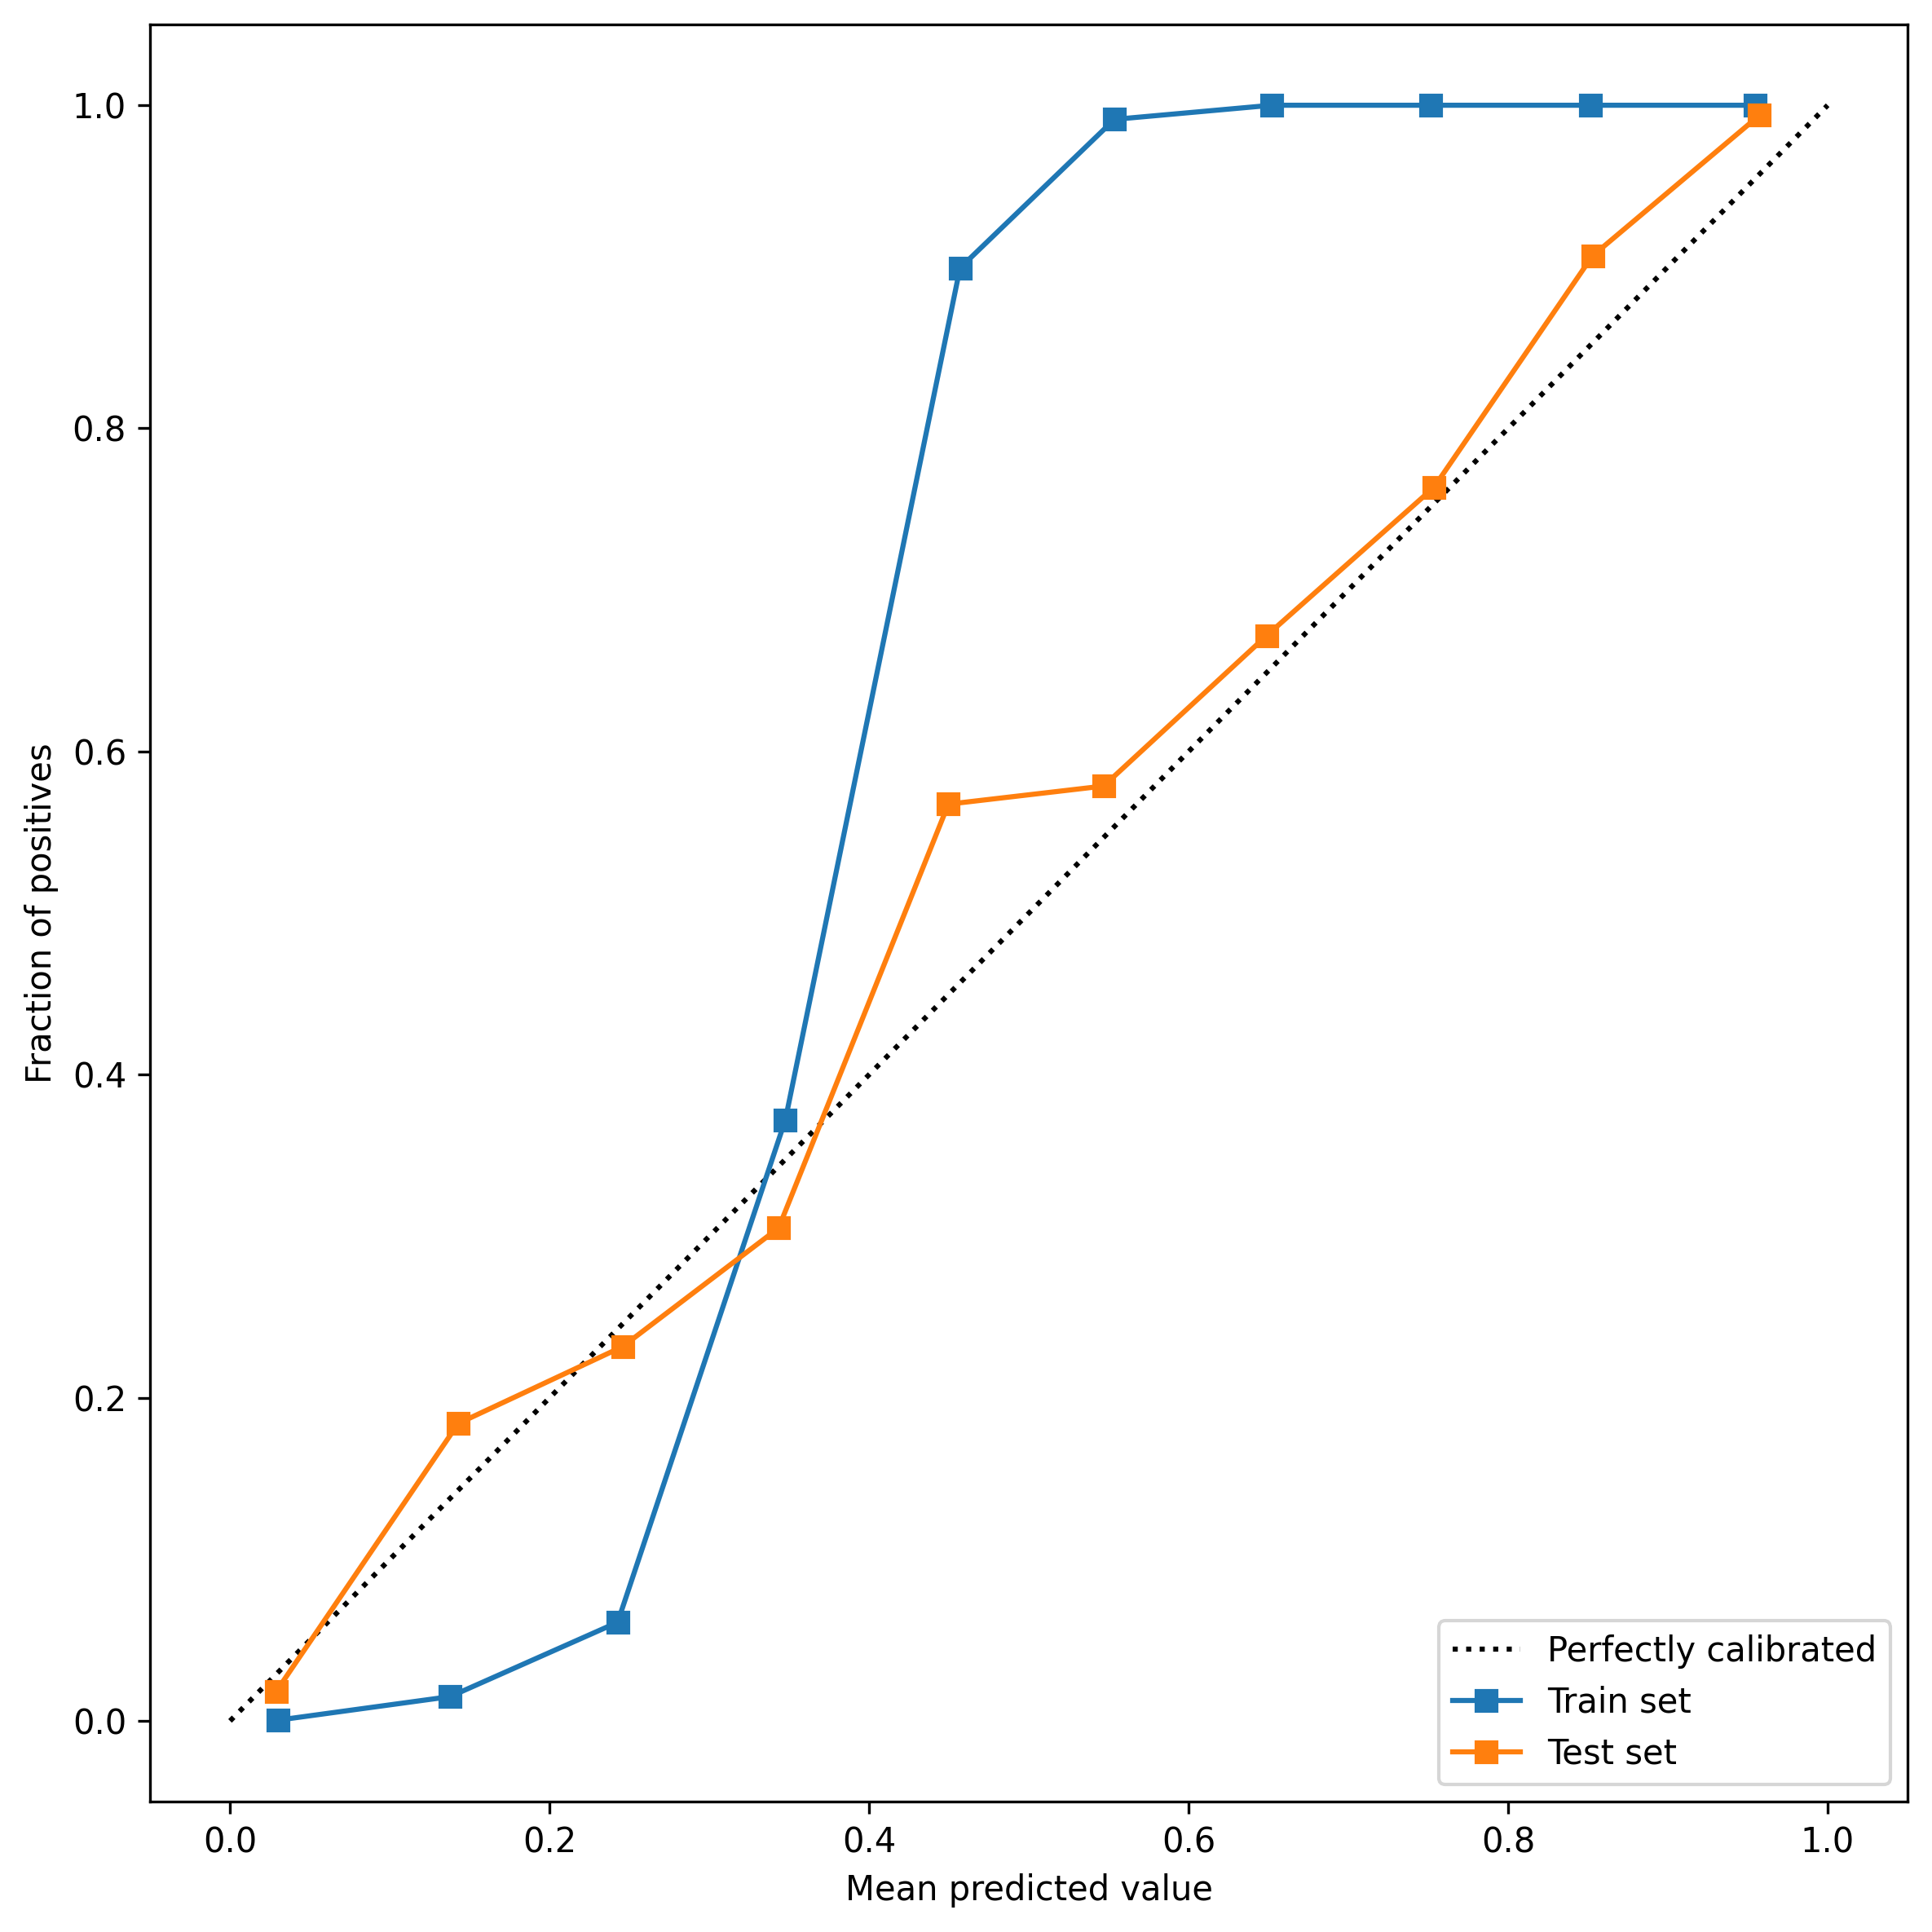

In [5]:
from sklearn.calibration import calibration_curve
def draw_calibration(labels, results,n=5):
    '''
    plot calibration curve
    :param labels:
    :param results:
    :param n:
    :return:
    '''
    
    plt.figure(0)
    plt.figure(dpi=300)
    plt.title("calibration_curve")
    ax1 = plt.subplot2grid((2, 1), (0, 0), rowspan=2)

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    label = np.array(labels[0])
    result = np.array(results[0])
    result = (result - result.min()) / (result.max() - result.min())
    fraction_of_positives, mean_predicted_value = calibration_curve(label, result, n_bins=n)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % ("Train set",))

    label = np.array(labels[1])
    result = np.array(results[1])
    result = (result - result.min()) / (result.max() - result.min())
    fraction_of_positives, mean_predicted_value = calibration_curve(label, result, n_bins=n)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % ("Test set",))




    ax1.set_ylabel("Fraction of positives")
    ax1.set_xlabel("Mean predicted value")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

plt.figure(dpi=300)
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
draw_calibration([train_y_lists,test_y_lists],[train_pre_lists,test_pre_lists],10)



0.7832786568900787


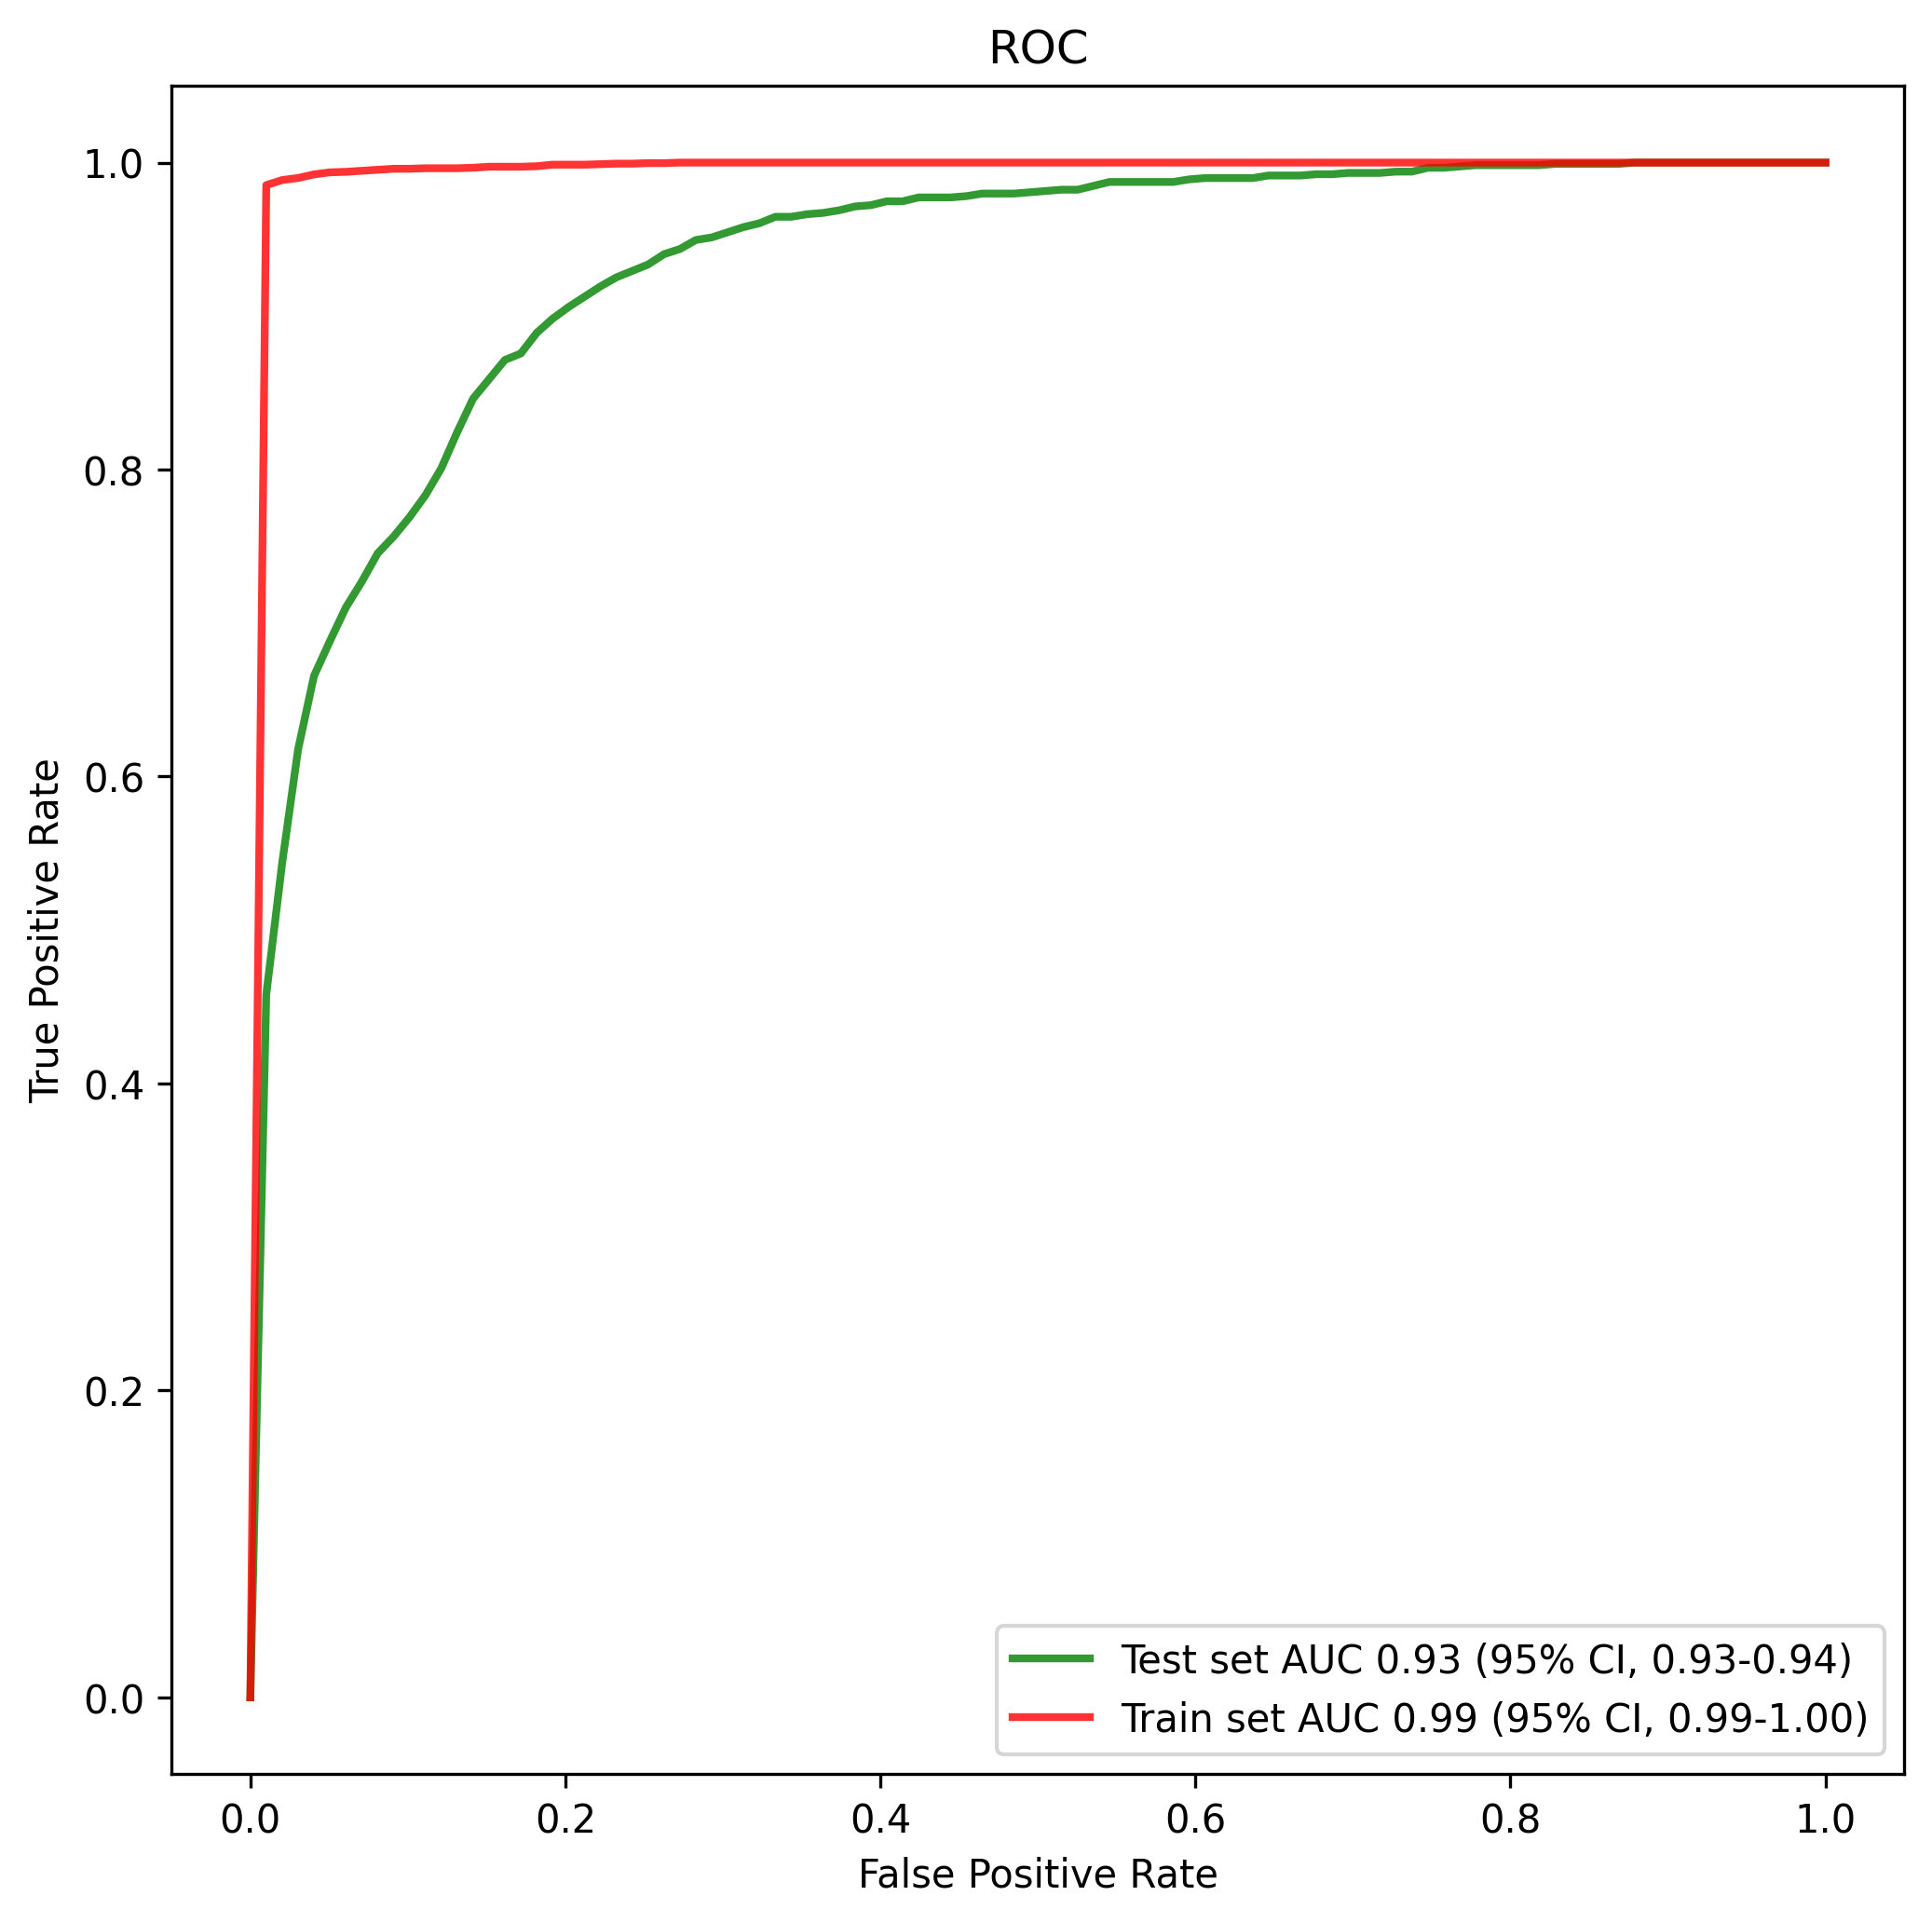

In [6]:
print(np.average(c))
finalpres = pd.DataFrame(bigtestresults)
finaltask = []
lss = []
for i in finalpres.columns:
    temp1 = finalpres.iloc[:, i].value_counts().index[0]
    lss.append(temp1)

mean_test_tpr=np.mean(test_tprs,axis=0)
mean_test_tpr[-1]=1.0
mean_test_auc=auc(mean_fpr,mean_test_tpr)
aucs=[]

for test_tpr in test_tprs:
    auc_=auc(mean_fpr,test_tpr)
    aucs.append(auc_)


'''
    计算置区间
'''
std_test_auc=np.std(aucs,axis=0)

low_=mean_test_auc-1.96*std_test_auc
upper=mean_test_auc+1.96*std_test_auc
plt.figure(dpi=300)
plt.plot(mean_fpr,mean_test_tpr,color='g',label=r'Test set AUC %.2f (95%% CI, %.2f-%.2f)' % (mean_test_auc,low_,upper),lw=2,alpha=0.8)


mean_train_tpr=np.mean(train_tprs,axis=0)
mean_train_tpr[-1]=1.0
mean_train_auc=auc(mean_fpr,mean_train_tpr)
aucs = []
for tpr in train_tprs:
    auc_ = auc(mean_fpr, tpr)
    aucs.append(auc_)

std_train_auc = np.std(aucs, axis=0)
low_=mean_train_auc-1.96*std_train_auc
upper=mean_train_auc+1.96*std_train_auc
plt.plot(mean_fpr,mean_train_tpr,color='r',label='Train set AUC %.2f (95%% CI, %.2f-%.2f)' % (mean_train_auc,low_,upper),lw=2,alpha=0.8)



#std_train_tpr=np.std(train_tprs,axis=0)
#train_tprs_upper=np.minimum(mean_train_tpr+std_train_tpr,1)
#train_tprs_lower=np.maximum(mean_train_tpr-std_train_tpr,0)
#plt.fill_between(mean_train_tpr,train_tprs_lower,train_tprs_upper,color='b',alpha=.2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
plt.show()


In [30]:
from sklearn.metrics import confusion_matrix
#[train_y_lists,test_y_lists],[train_pre_lists,test_pre_lists]
results = []
for pred in test_pre_lists[0:713]: 
    result = 1 if pred > .05 else 0
    results.append(result)
print("混淆矩阵：:",confusion_matrix(y_test, results))
print("准确率:",accuracy_score(y_test, results))
print("真阳性率:",precision_score(y_test, results))
print("F1:",f1_score(y_test, results))
print('recall',recall_score(y_test, results))

混淆矩阵：: [[382 212]
 [  3 116]]
准确率: 0.6984572230014026
真阳性率: 0.35365853658536583
F1: 0.5190156599552572
recall 0.9747899159663865


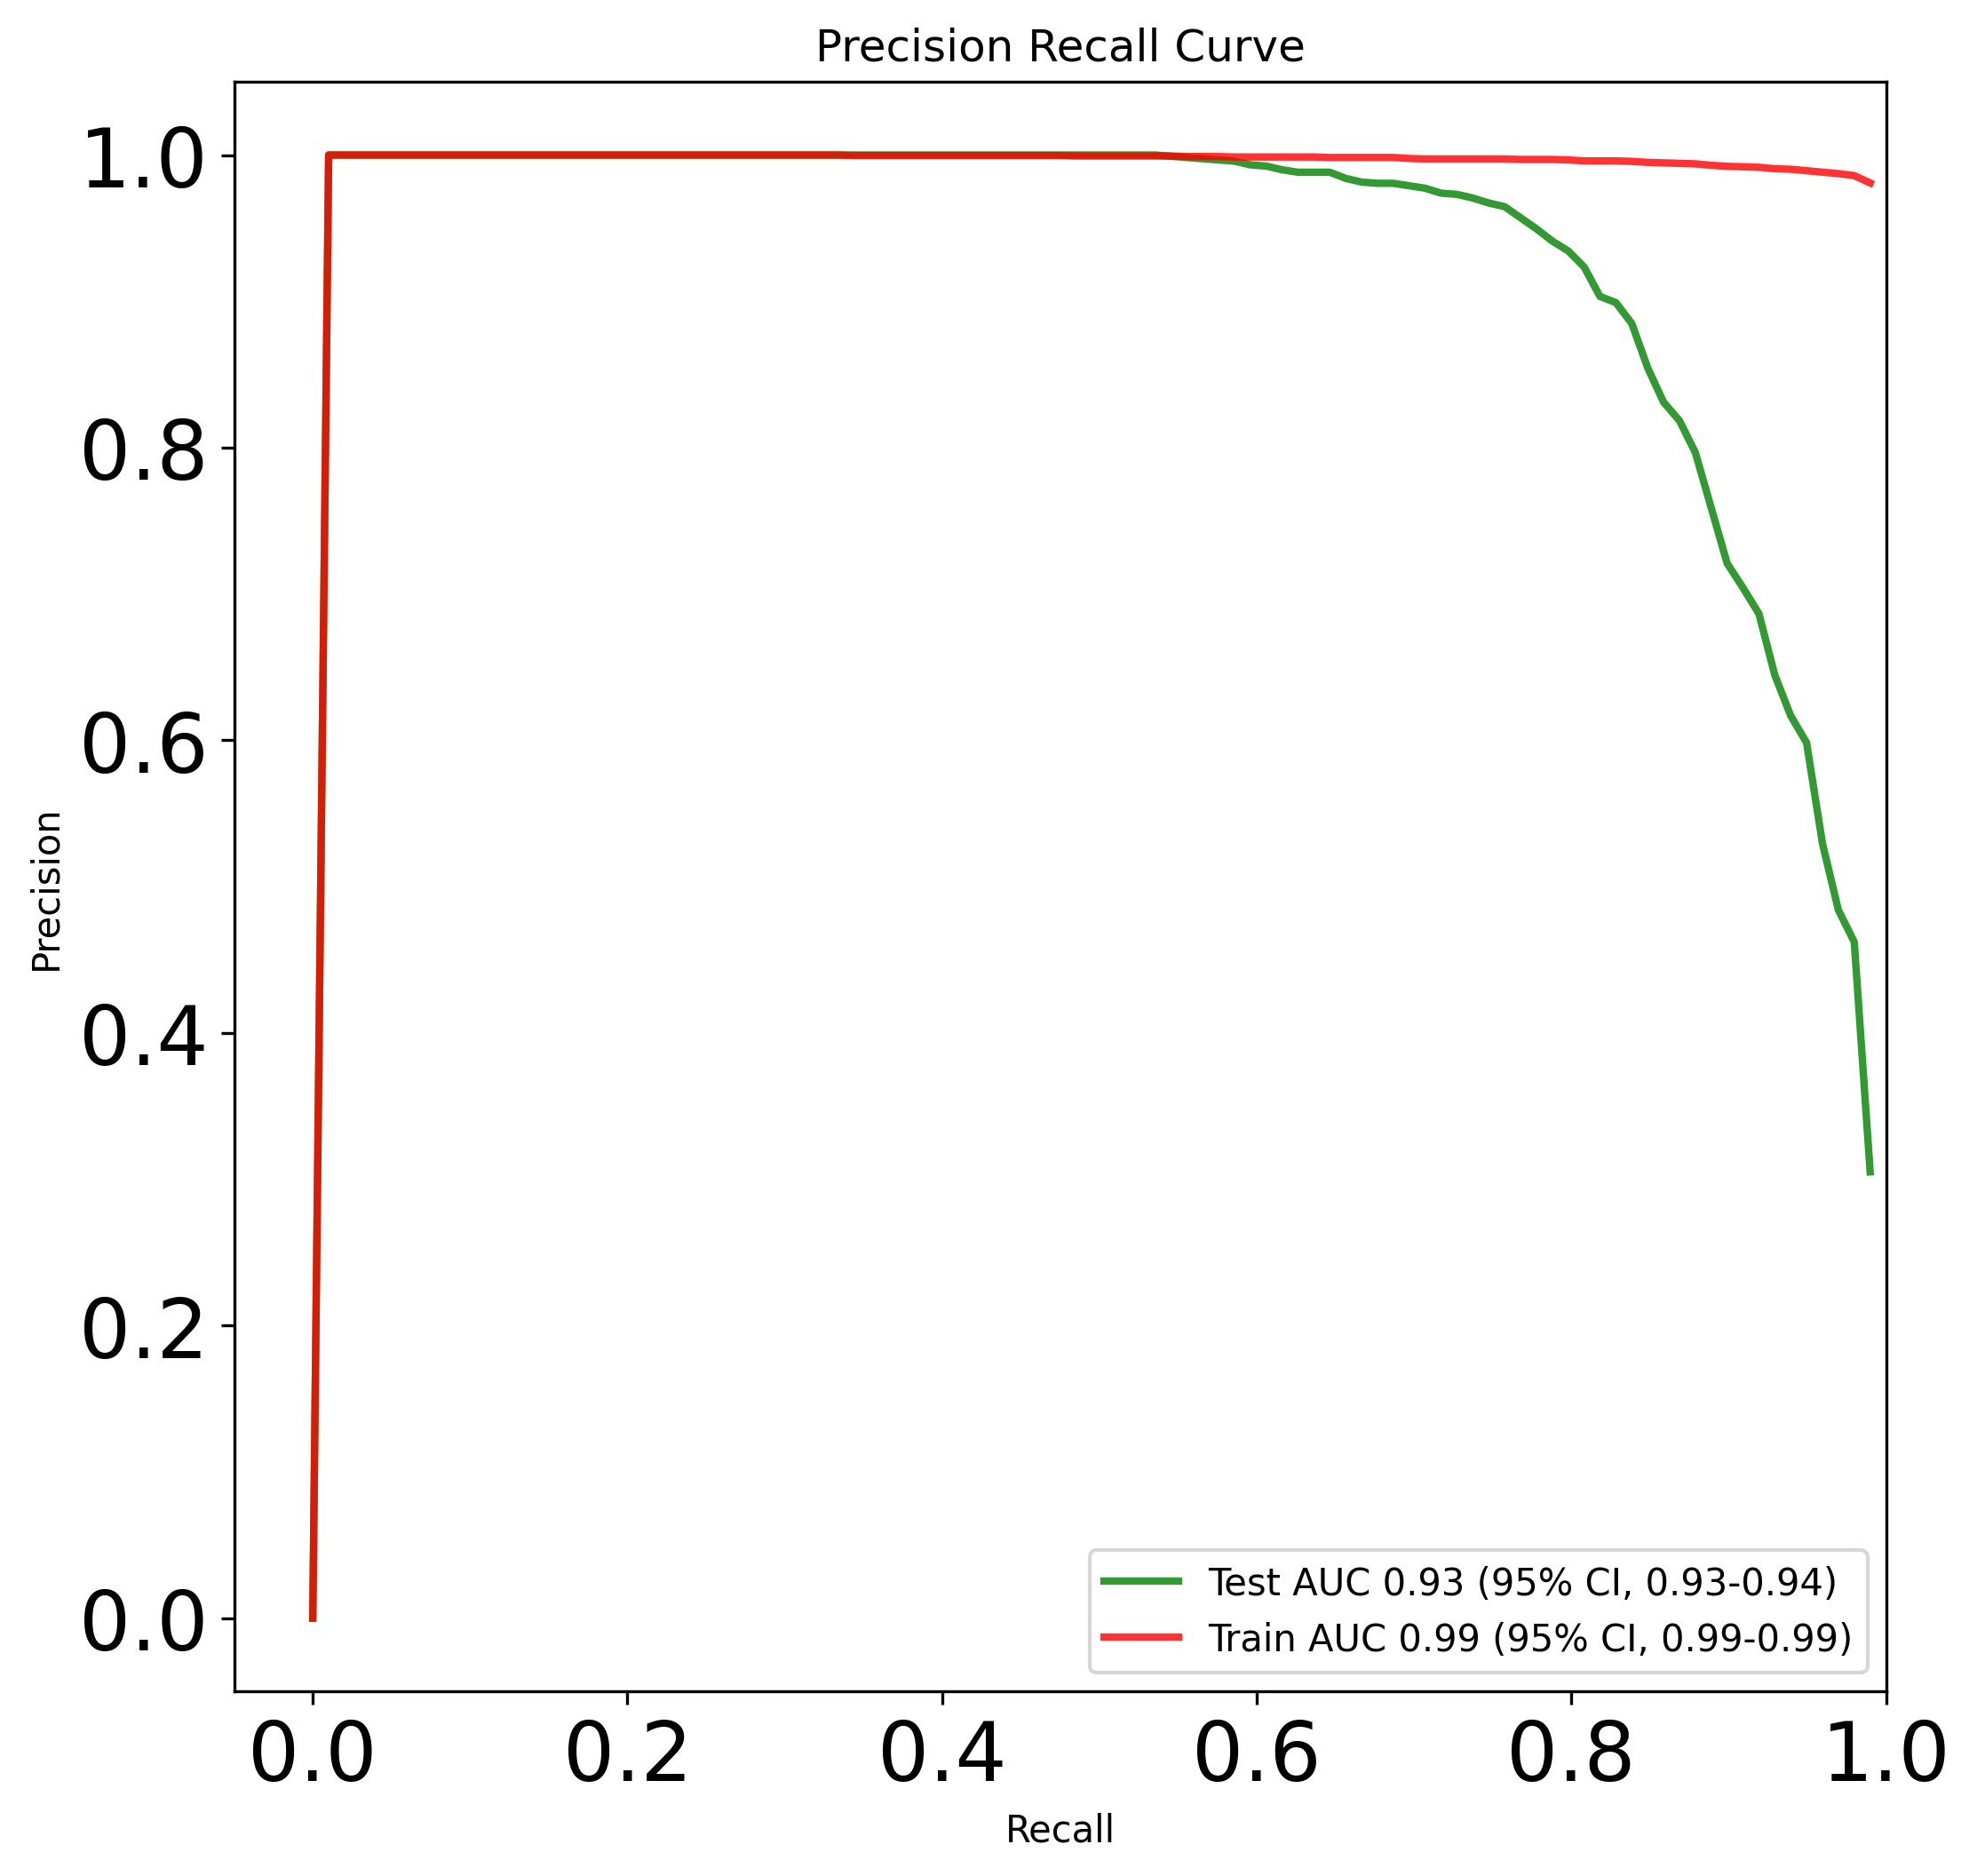

In [16]:
#Plot PR ROC


mean_test_precision=np.mean(test_precisions,axis=0)
mean_test_precision[-1]=1.0
mean_test_auc=auc(mean_recall,mean_test_precision)
aucs=[]

for test_precision in test_precisions:
    auc_=auc(mean_recall,test_precision)
    aucs.append(auc_)


'''
    计算置区间
'''
std_test_auc=np.std(aucs,axis=0)

low_=mean_test_auc-1.96*std_test_auc
upper=mean_test_auc+1.96*std_test_auc
plt.figure(dpi=300)
plt.plot(mean_recall[:-1],mean_test_precision[:-1],color='g',label=r'Test AUC %.2f (95%% CI, %.2f-%.2f)' % (mean_test_auc,low_,upper),lw=2,alpha=0.8)


mean_train_precision=np.mean(train_precisions,axis=0)
mean_train_precision[-1]=1.0
mean_train_auc=auc(mean_recall,mean_train_precision)
aucs = []
for train_precision in train_tprs:
    auc_ = auc(mean_recall, train_precision)
    aucs.append(auc_)

std_train_auc = np.std(aucs, axis=0)
low_=mean_train_auc-1.96*std_train_auc
upper=mean_train_auc+1.96*std_train_auc
plt.plot(mean_recall[:-1],mean_train_precision[:-1],color='r',label='Train AUC %.2f (95%% CI, %.2f-%.2f)' % (mean_train_auc,low_,upper),lw=2,alpha=0.8)



#std_train_tpr=np.std(train_tprs,axis=0)
#train_tprs_upper=np.minimum(mean_train_tpr+std_train_tpr,1)
#train_tprs_lower=np.maximum(mean_train_tpr-std_train_tpr,0)
#plt.fill_between(mean_train_tpr,train_tprs_lower,train_tprs_upper,color='b',alpha=.2)

plt.xlim([-0.05, 1.00])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc='lower right')
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
plt.show()


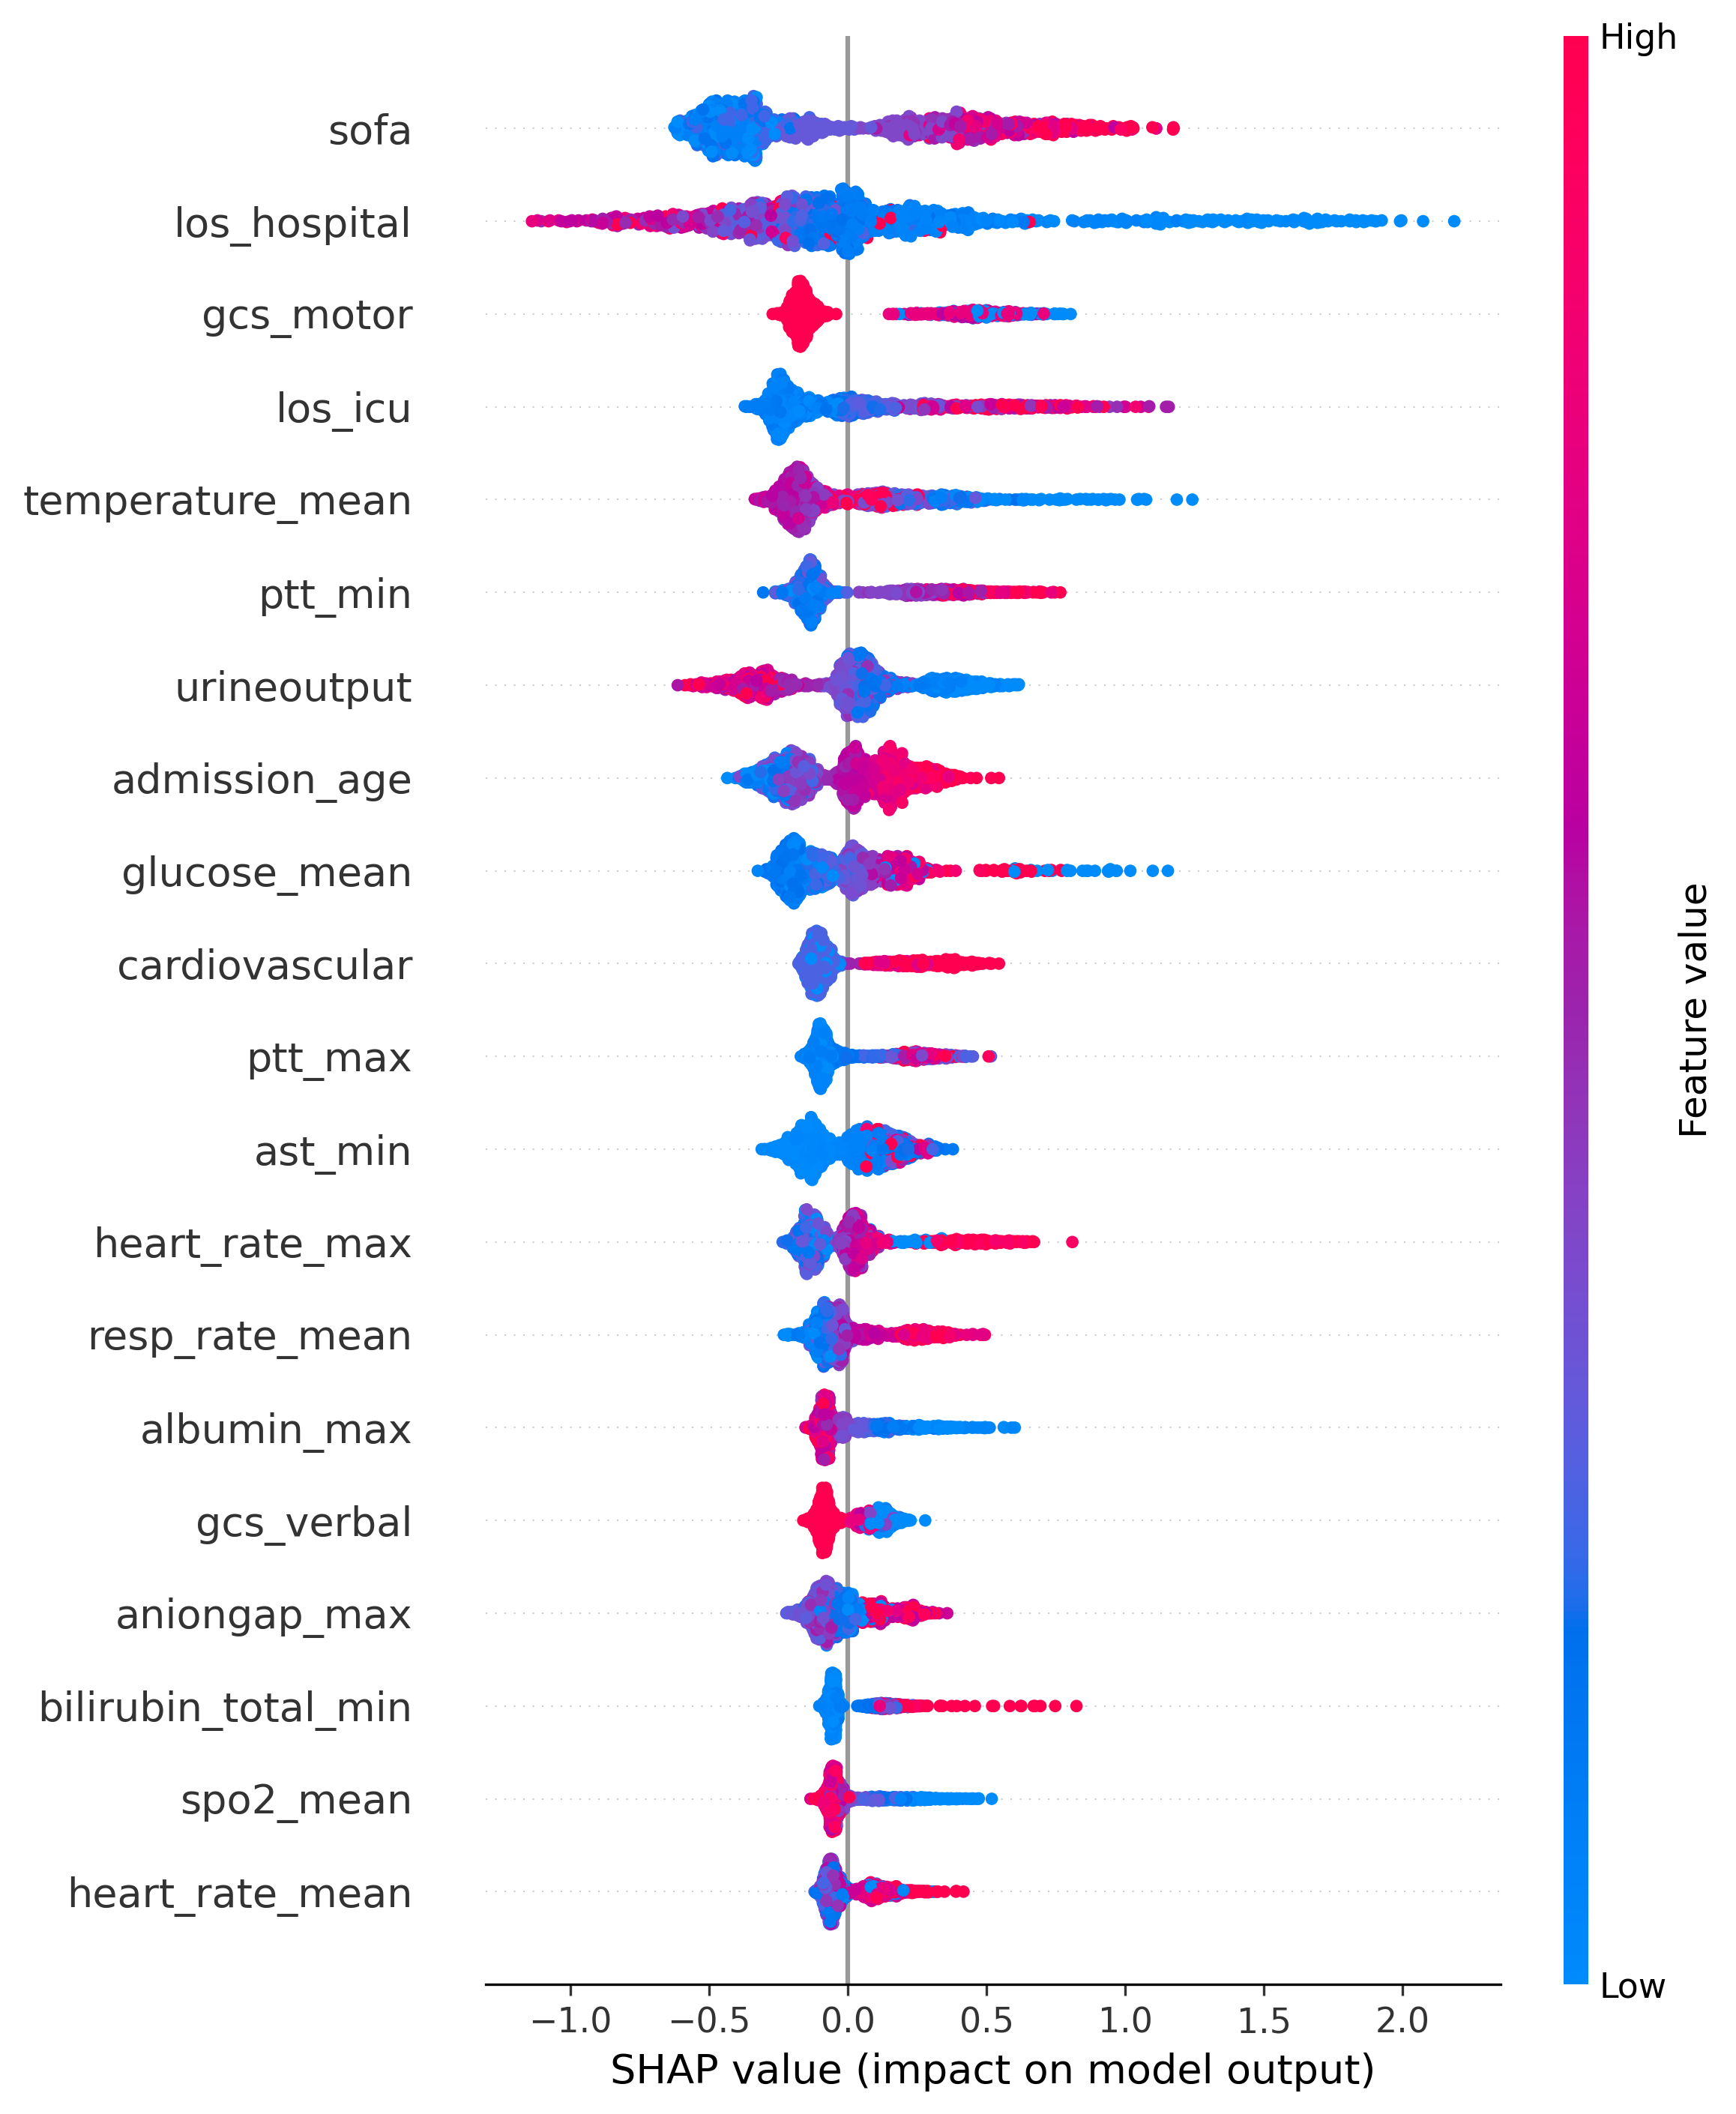

In [17]:
shap.initjs()
plt.figure(figsize=(16,18),dpi = 300)
shap.summary_plot(shap_values[1], train_x)

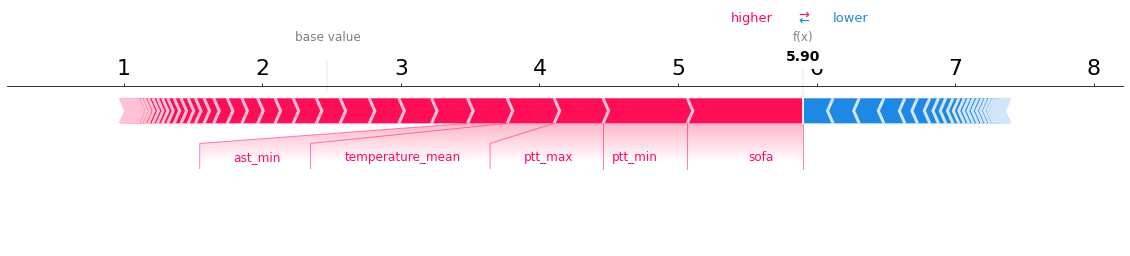

In [25]:
shap.initjs()
# visualize the first prediction's explanation with a force plot
shap.force_plot(explainer.expected_value[0], shap_values[1][17],features,matplotlib= True)

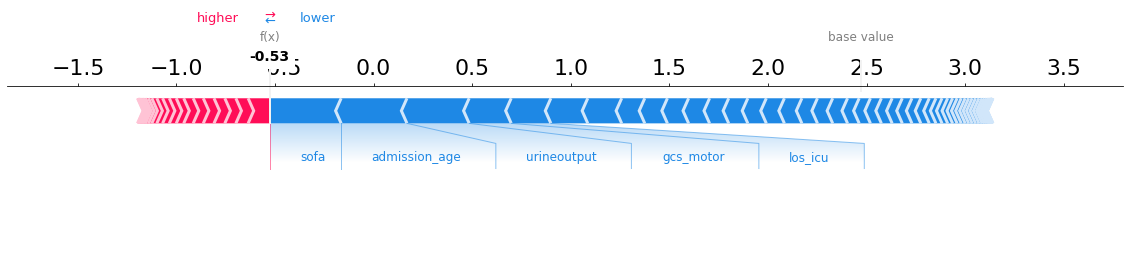

In [21]:
shap.initjs()
# visualize the first prediction's explanation with a force plot
shap.force_plot(explainer.expected_value[0], shap_values[1][9],features,matplotlib= True)